In [94]:
# Standard packages
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data Preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

# Data

In [95]:
op = pd.read_csv('order_products__train.csv')
opp = pd.read_csv('order_products__prior.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
tips_tr = pd.read_csv('tip_trainingsdaten.csv', index_col=0)
tips_prod = pd.read_csv('tip_testdaten.csv', index_col=0)

c:\Users\jdhau\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [96]:
opp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [97]:
opp = pd.concat([opp, op], ignore_index=True)

In [98]:
opp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 1.0 GB


Mithilfe eines Algorithmus werden die Datentypen der Tabellen optimimiert. Dies erhöht die Performance.

In [99]:
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object]:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')

    return train_data

orders = reduce_mem_usage(orders)
opp = reduce_mem_usage(opp)
aisles = reduce_mem_usage(aisles)
departments = reduce_mem_usage(departments)
products = reduce_mem_usage(products)

Memory usage of dataframe is 182.71 MB
Memory usage of dataframe is 1032.08 MB
Memory usage of dataframe is 0.00 MB
Memory usage of dataframe is 0.00 MB
Memory usage of dataframe is 1.52 MB


Merge orders and tips

In [100]:
instacart_train = tips_tr.merge(orders)
instacart_prod = tips_prod.merge(orders)

Merge opp, aisles and departments

In [101]:
opp_reduced = opp.groupby('order_id').head(1)

In [102]:
products_departments = products.drop(columns=['product_name', 'aisle_id']).set_index('product_id').to_dict()['department_id']
opp['departments_id'] = opp['product_id'].map(products_departments, na_action='ignore')

products_aisles = products.drop(columns=['product_name', 'department_id']).set_index('product_id').to_dict()['aisle_id']
opp['aisles_id'] = opp['product_id'].map(products_aisles, na_action='ignore')

In [103]:
opp['value'] = 1
opp_aisles = opp.pivot_table(index=['order_id'], columns=['aisles_id'], values='value', margins=False, aggfunc='any').add_prefix('aisles_')

aisles_list = aisles['aisle'].to_list()
opp_aisles_names = opp_aisles.columns.to_list()
opp_aisles.columns = ["" + opp_aisles_names[index] + " " + aisles_list[index] for index in range(0,134)]

opp_aisles = opp_aisles.fillna(False)
opp_aisles = reduce_mem_usage(opp_aisles)

opp_reduced = opp_reduced.merge(opp_aisles, left_on='order_id', right_index=True, suffixes=('', 'aisles_'))

Memory usage of dataframe is 453.13 MB


In [104]:
opp['value'] = 1
opp_departments = opp.pivot_table(index=['order_id'], columns=['departments_id'], values='value', margins=False, aggfunc='any').add_prefix('departments_')

departements_list = departments['department'].to_list()
opp_department_names = opp_departments.columns.to_list()
opp_departments.columns = ["" + opp_department_names[index] + " " + departements_list[index] for index in range(0,21)]

opp_departments = opp_departments.fillna(False)
opp_departments = reduce_mem_usage(opp_departments)

opp_reduced = opp_reduced.merge(opp_departments, left_on='order_id', right_index=True, suffixes=('', 'departments_'))

Memory usage of dataframe is 92.54 MB


In [105]:
opp_reduced

,order_id,product_id,add_to_cart_order,reordered,aisles_1 prepared soups salads,aisles_2 specialty cheeses,aisles_3 energy granola bars,aisles_4 instant foods,aisles_5 marinades meat preparation,aisles_6 other,...,departments_12 meat seafood,departments_13 pantry,departments_14 breakfast,departments_15 canned goods,departments_16 dairy eggs,departments_17 household,departments_18 babies,departments_19 snacks,departments_20 deli,departments_21 missing
0,2,33120,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,3,33754,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17,4,46842,1,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30,5,13176,1,1,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
56,6,40462,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819080,3421049,40800,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
33819086,3421056,5750,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
33819091,3421058,15629,1,1,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
33819099,3421063,49235,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [106]:
instacart_train = instacart_train.merge(opp_reduced.drop(columns=['add_to_cart_order', 'reordered', 'product_id']), left_on='order_id', right_on='order_id')
instacart_prod = instacart_prod.merge(opp_reduced.drop(columns=['add_to_cart_order', 'reordered', 'product_id']), left_on='order_id', right_on='order_id')


In [107]:
instacart_train.isnull().sum().head(20)

order_id                                    0
tip                                         0
user_id                                     0
eval_set                                    0
order_number                                0
order_dow                                   0
order_hour_of_day                           0
days_since_prior_order                 206209
aisles_1 prepared soups salads              0
aisles_2 specialty cheeses                  0
aisles_3 energy granola bars                0
aisles_4 instant foods                      0
aisles_5 marinades meat preparation         0
aisles_6 other                              0
aisles_7 packaged meat                      0
aisles_8 bakery desserts                    0
aisles_9 pasta sauce                        0
aisles_10 kitchen supplies                  0
aisles_11 cold flu allergy                  0
aisles_12 fresh pasta                       0
dtype: int64

In [108]:
instacart_prod.isnull().sum().head(20)

order_id                                    0
tip                                    131209
user_id                                     0
eval_set                                    0
order_number                                0
order_dow                                   0
order_hour_of_day                           0
days_since_prior_order                      0
aisles_1 prepared soups salads              0
aisles_2 specialty cheeses                  0
aisles_3 energy granola bars                0
aisles_4 instant foods                      0
aisles_5 marinades meat preparation         0
aisles_6 other                              0
aisles_7 packaged meat                      0
aisles_8 bakery desserts                    0
aisles_9 pasta sauce                        0
aisles_10 kitchen supplies                  0
aisles_11 cold flu allergy                  0
aisles_12 fresh pasta                       0
dtype: int64

# Business Understanding

In der Aufgaben geht es um einen Lieferdienst namens Instacart, bei dem Kunden Bestellungen aufgeben
können. Instacart schickt dann Fahrer los , die die Ware in
Supermärkten abholen und zum Kunden bringen. 
<br>
Dieser Datensatz enthält eine zusätzliche Spalte „Tip“, die zu den einzelnen
Bestellungen angibt, ob der Kunden beim Erhalt der Ware ein Trinkgeld gegeben hat oder nicht. Kern
der Aufgabe ist vorherzusagen, bei welchen Bestellungen Trinkgeld gegeben werden wird und bei
welchen nicht. 

### 1. Tip-Prediction
Es soll vorhergesagt werden, bei welchen Bestellungen die Kunden dem Fahrer Trinkgeld
gegeben werden und bei welchen nicht. Die Vorhersage kann dabei auf allen Informationen
basieren, die unmittelbar nach Aufgeben der Bestellung zur Verfügung stehen, d.h. alle
Daten zur aktuellen Bestellung sowie die gesamte Vorgeschichte. 
Zielerwartung sind mindestens 70% Genauigkeit bei der Vorhersage, ob ein Tip erfolgen wird oder nicht.

### 2. Analyse der Tip-Einflussfaktoren
Zusätzlich sollen auch interpretierbare Erkenntnisse geliefert werden, wovon es abhängt, ob
Trinkgeld gegeben wird. Diese sollen nachvollziehbar dargestellt werden. 

# Data Understanding

## Beschreibung der Daten

Der Instacart Datensatz besteht aus über 3.2 Millionen Bestellungen. Er ist aufgeteilt in die Datentabellen: 
- orders: Information über die Bestellungen.
- opp: Information über die in den Bestellungen enthaltenen Produkte.
- tips: Information ob ein tip gegeben wurde, oder nicht.
- products: Information zu den bestellbaren Produkten. Es sind fast 50.000 Produkte vorhanden, welche über 4 Spalten beschrieben werden. Der Datensatz ist vollständig, es gibt keine Null-Werte. 
- aisles: Information zu den Inseln, in welchen die Produkte angeboten werden. Im Datensatz sind 134 Supermarktgänge gelistet, welche durch eine schriftliche Beschreibung genau aussagen, was in diesem Gang zu finden ist. 
- departements: Information zu den Abteilungen, in welchen die Produkte angeboten werden. Es gibt 21 Abteilungen , in welche jedes Proukt eingeordnet wird. Der Datensatz besteht aus zwei Spalten. 

Im ersten Schritt wurden orders und tips verbunden. Über eine Aggregation wurden zudem die Information zu den Aisles und Departements der in einer Bestellung enthaltenen Produkte integriert.
Die Daten pro Bestellung sind vollständig, bis auf den Wochentag der Bestellung (order_dow), bei dem Werte mit nan angegeben sind, welche später behandelt werden werden. Alle Daten sind ganzzahlige Werte (int), außer days_since_prior_order, welches ein Kommazahlenwert (float) ist. Eine weitere Ausnahme ist das Objekt eval_set.
Für die Optmierung der Datentypen wurden die Speicherbereiche für die int- und float-Werte jeweils minimal gewählt.

Im folgenden werden die bestehenden Features beschrieben. Die in der Feature Creation erstellten Features werden mit "created" gekennzeichnet.

In [109]:
instacart_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3214873
Columns: 163 entries, order_id to departments_21 missing
dtypes: category(1), float16(156), int32(1), int64(2), int8(3)
memory usage: 1.0 GB


In [110]:
instacart_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131209 entries, 0 to 131208
Columns: 163 entries, order_id to departments_21 missing
dtypes: category(1), float16(156), float64(1), int32(1), int64(1), int8(3)
memory usage: 43.0 MB


### order_id
- Numerisches Features, welches für jede Bestellung eine einzigartige ID enthält. Insgesamt gibt es 3.214.874 Millionen distinkte Bestellungen.

In [111]:
instacart_train['order_id'].nunique()

3214874

### user_id
- Numerisches Feature, welches für jeden distinkten Nutzer eine einzigeartige ID enthält. Die Bestellungen wurden von 206209 distinkten Nutzern getätigt.

In [112]:
instacart_train['user_id'].nunique()

206209

### tip
- Binäres Features mit der Information, ob ein Tip gebeben wurde. 0 bedeutet, dass kein Tip gegeben wurde, 1 bedeutet, dass ein Tip gegeben wurde. 
- Bei circa 1.9 Millionen Bestellungen wurde Trinkgeld gegeben, bei 1.4 Millionen nicht. 

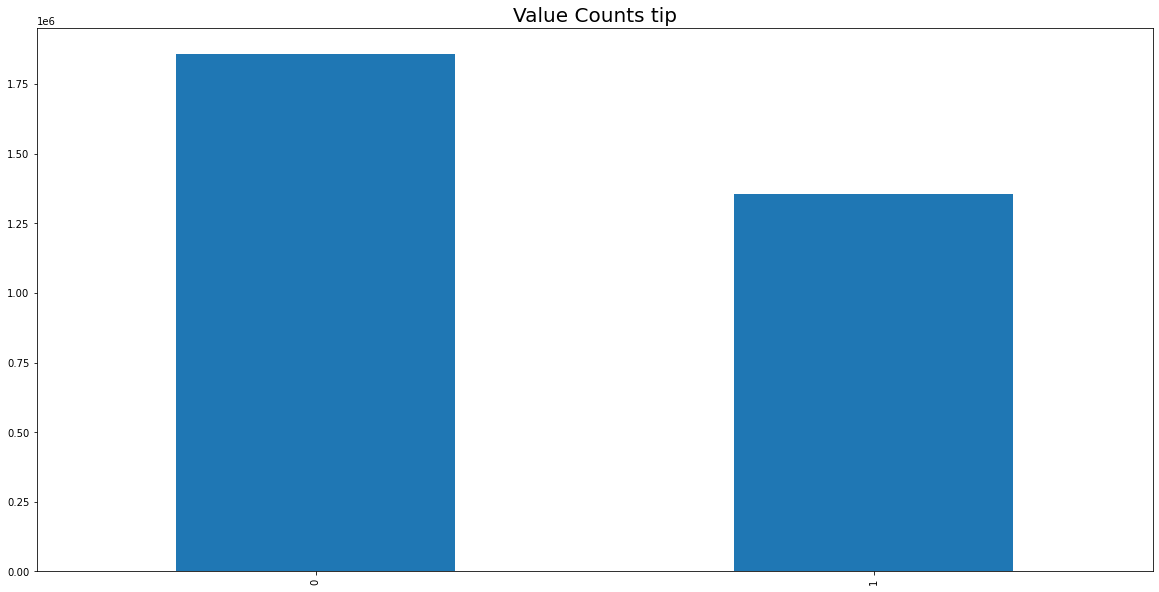

In [113]:
plt.figure(figsize=(20, 10))
ax = instacart_train['tip'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts tip', fontsize = 20)
plt.show()

### eval_set
- Kategorisches Features mit der Information zu welchem Set die Beobachtung gehört. Verfügbare Werte sind: train und test. Train kann für das Training benutzt werden. Für Test-Beobachtungen soll eine Vorhersage generiert werden. Das Feature ist daher im Trainingsset stetig und enthält keine weitere Information.

In [114]:
instacart_train['eval_set'].nunique()

1

### order_number
- Numerisches Features mit der Information, die wievielte Bestellung die des jeweiligen Nutzers die Beobachtung ist.
- Jede Person hat mindestens 3 Mal und maximal 99 Mal bestellt. Durchschnittlich hat jede Person ca. 17 Bestellungen aufgegeben. 

In [115]:
instacart_train['order_number'].mean()

17.191065652961825

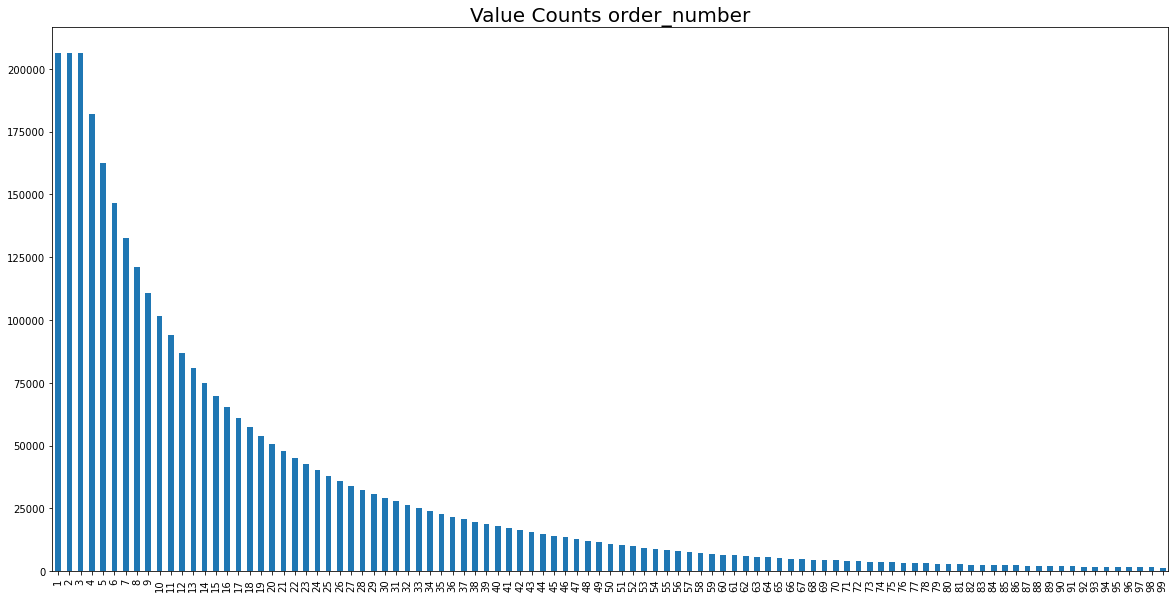

In [116]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_number'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_number', fontsize = 20)
plt.show()

### order_dow
- Numerisches Features mit der Information über den Wochentag der Bestellung. Die Information ist als Zahl zwischen 0 und 6 encodiert. Es wird angenommen, dass die Tage 0 und 1 mit mehr Bestellungen die Tage Samstag und Sonntag sind. Die weiteren Tage sind in der üblichen Reihenfolge.
- Die meisten Bestellungen erfolgen am Wochenende.

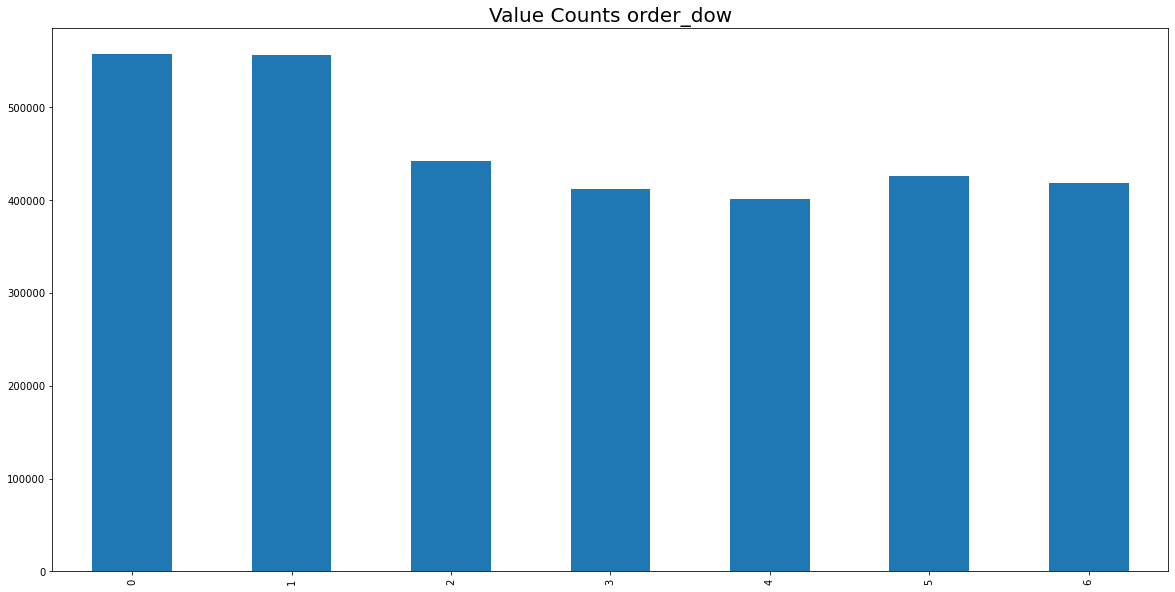

In [117]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_dow'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_dow', fontsize = 20)
plt.show()

### order_hour_of_day
- Numerisches Features mit der Information über die Uhrzeit der Bestellung.
- Die wenigsten Bestellungen gehen rund um 3 Uhr nachts ein, die meisten um 10 Uhr vormittags. 

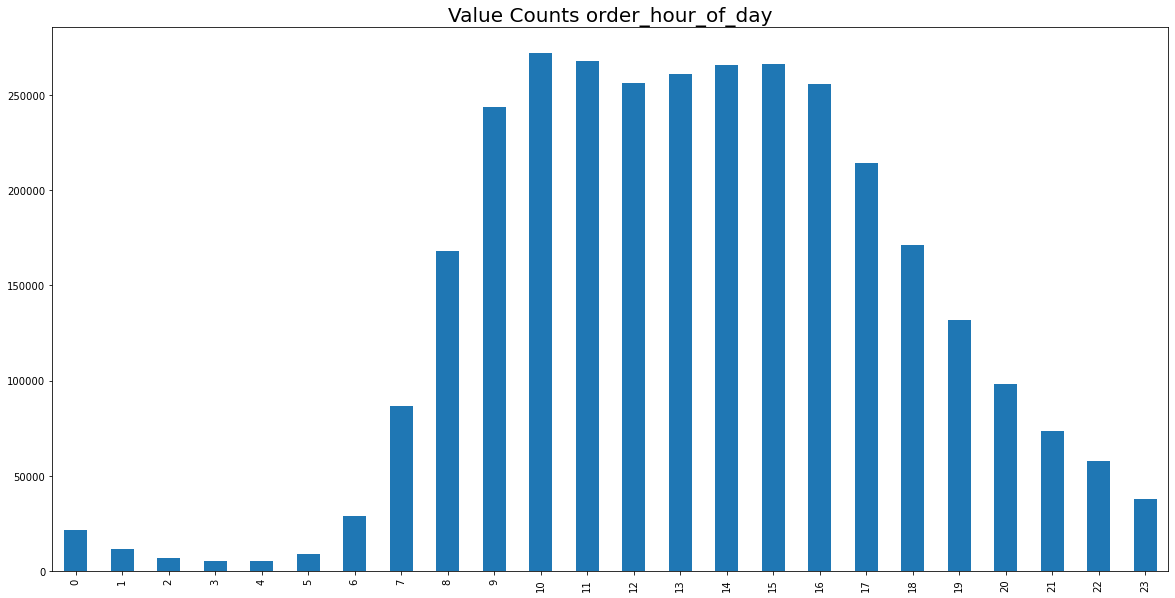

In [118]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_hour_of_day'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_hour_of_day', fontsize = 20)
plt.show()

### days_since_prior_order
- Numerisches Feature mit der Information über die Anzahl der vergangengen Tage seit der letzten seit der letzten Bestellung.
- Es vergehen zwischen keinem und mehr als 30 Tage, bis die Personen erneut bestellen. Der Durchschnitt des Features ist alle 10,7 Tage.

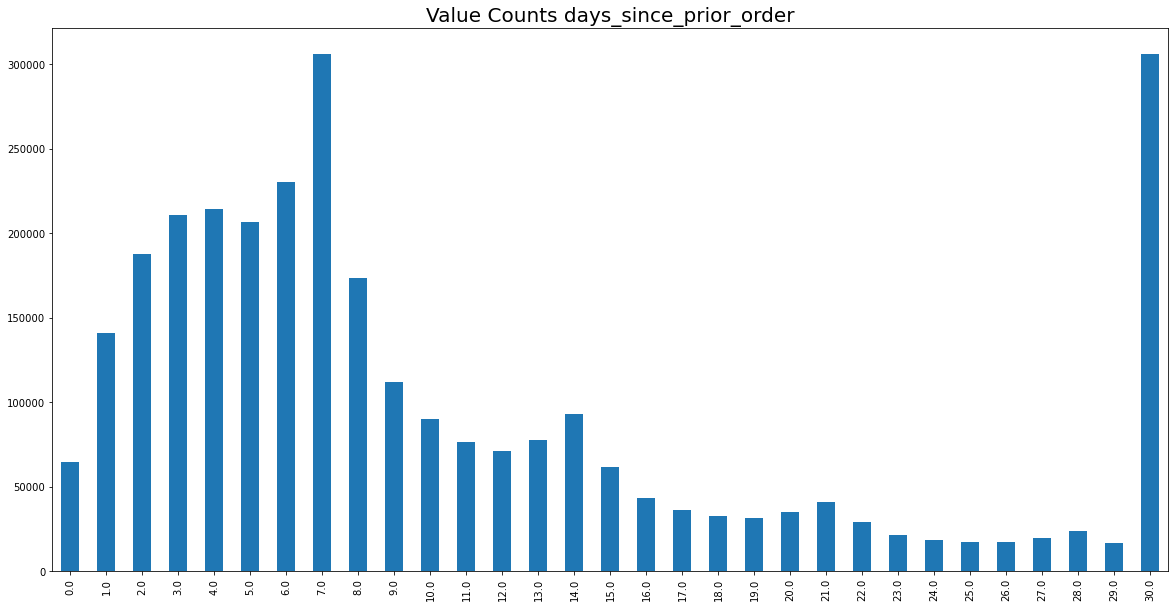

In [119]:
plt.figure(figsize=(20, 10))
ax = instacart_train['days_since_prior_order'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts days_since_prior_order', fontsize = 20)
plt.show()

### aisles_X
- 134 Numerische Features, die beschreiben, welchen Insel die bestellten Produkte zugeordnet sind. 0 beschreibt, dass ein Bestellung keinen Artikel aus der jeweiligen Insel beinhaltet. 1 beschreibt, dass mindestens ein Artikel aus der Insel enthalten ist.

C:\Users\jdhau\AppData\Local\Temp/ipykernel_10788/4023421126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instacart_train_aisles[col] = instacart_train_aisles[col].astype(np.int64)


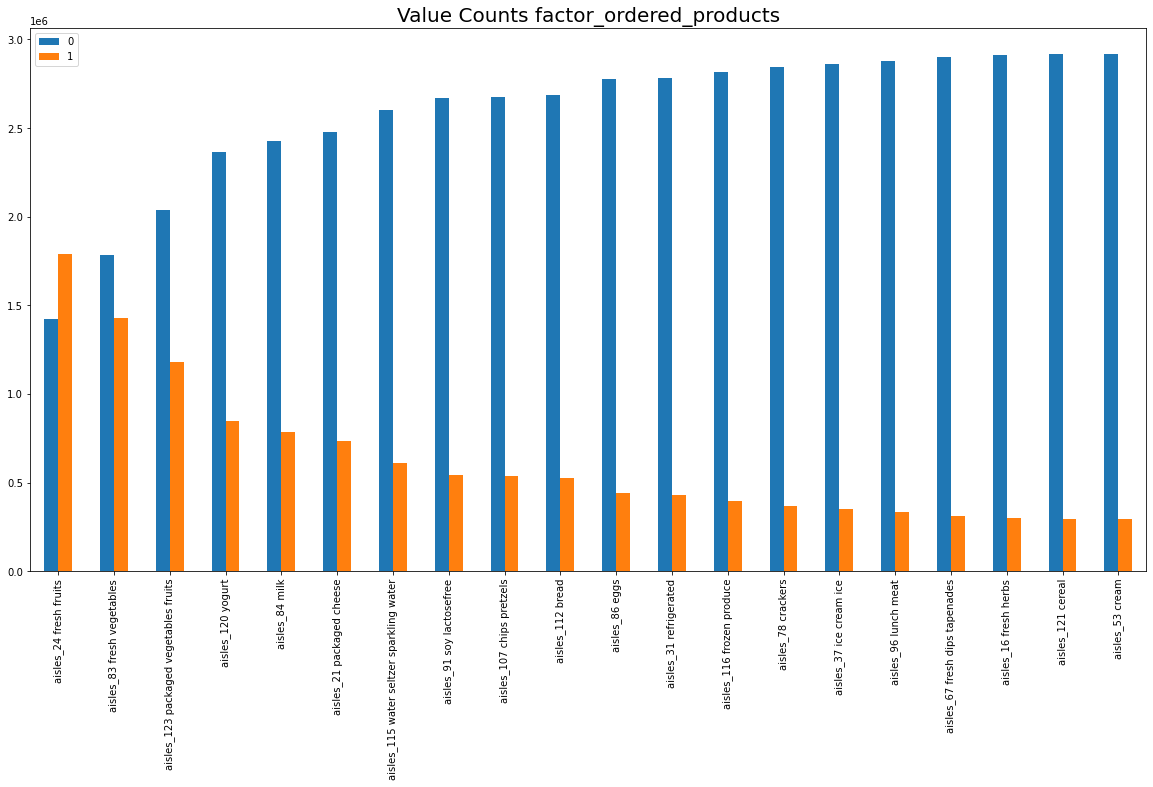

In [120]:
instacart_train_aisles = instacart_train.loc[:,instacart_train.columns.str.contains('aisles|tip')]

for col in instacart_train_aisles.columns:
    instacart_train_aisles[col] = instacart_train_aisles[col].astype(np.int64)  

ax = instacart_train_aisles.drop(columns=['tip']).apply(pd.Series.value_counts).T.sort_values(by=[1],ascending=False).head(20).plot(kind='bar', figsize=(20,10))
ax.set_title(label = 'Value Counts factor_ordered_products', fontsize = 20)
plt.show()

### departments_X
- 21 Numerische Features, die beschreiben, welcher Abteilung die bestellten Produkte zugeordnet sind. 0 beschreibt, dass ein Bestellung keinen Artikel aus der Abteilung beinhaltet. 1 beschreibt, dass mindestend ein Artikel aus der Abteilung enthalten ist.

C:\Users\jdhau\AppData\Local\Temp/ipykernel_10788/3127542522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instacart_train_departements[col] = instacart_train_departements[col].astype(np.int64)


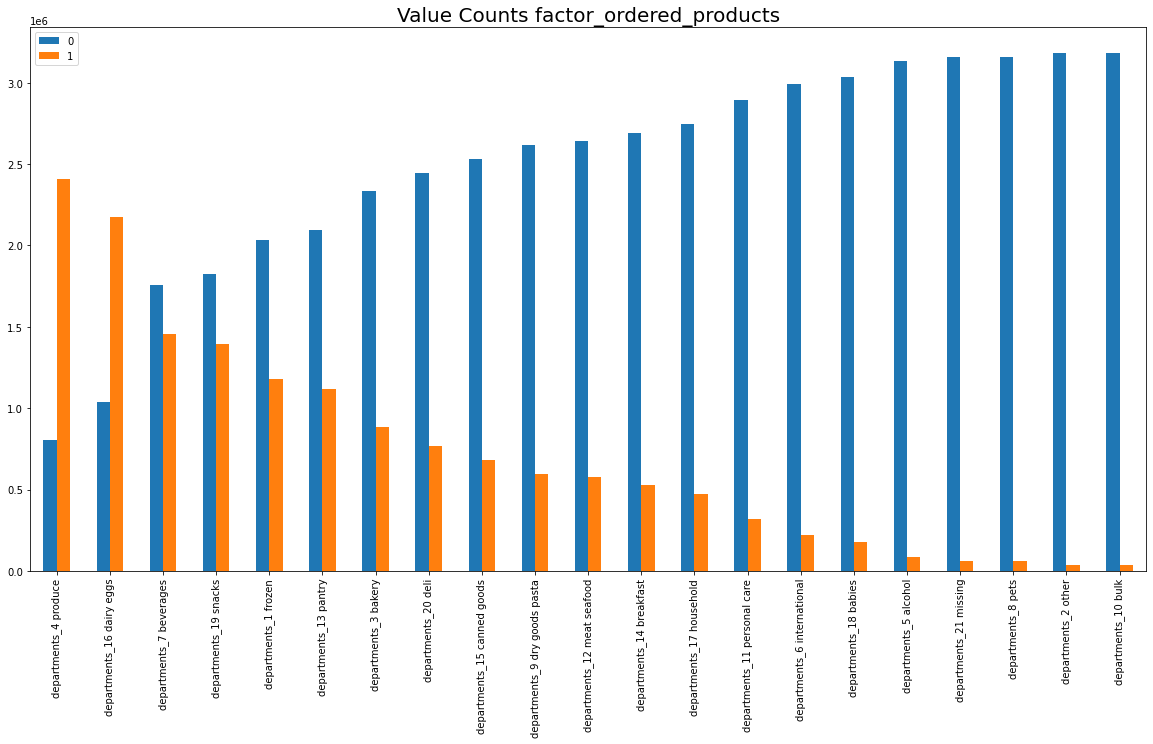

In [121]:
instacart_train_departements = instacart_train.loc[:,instacart_train.columns.str.contains('departments|tip')]

for col in instacart_train_departements.columns:
    instacart_train_departements[col] = instacart_train_departements[col].astype(np.int64)  

ax = instacart_train_departements.drop(columns=['tip']).apply(pd.Series.value_counts).T.sort_values(by=[1],ascending=False).plot(kind='bar', figsize=(20,10))
ax.set_title(label = 'Value Counts factor_ordered_products', fontsize = 20)
plt.show()

### created: mean_tip_user
- Numerisches Feature, welche pro Nutzer der Durchschnitt der bei Bestellungen gegebenen tip verwendet.

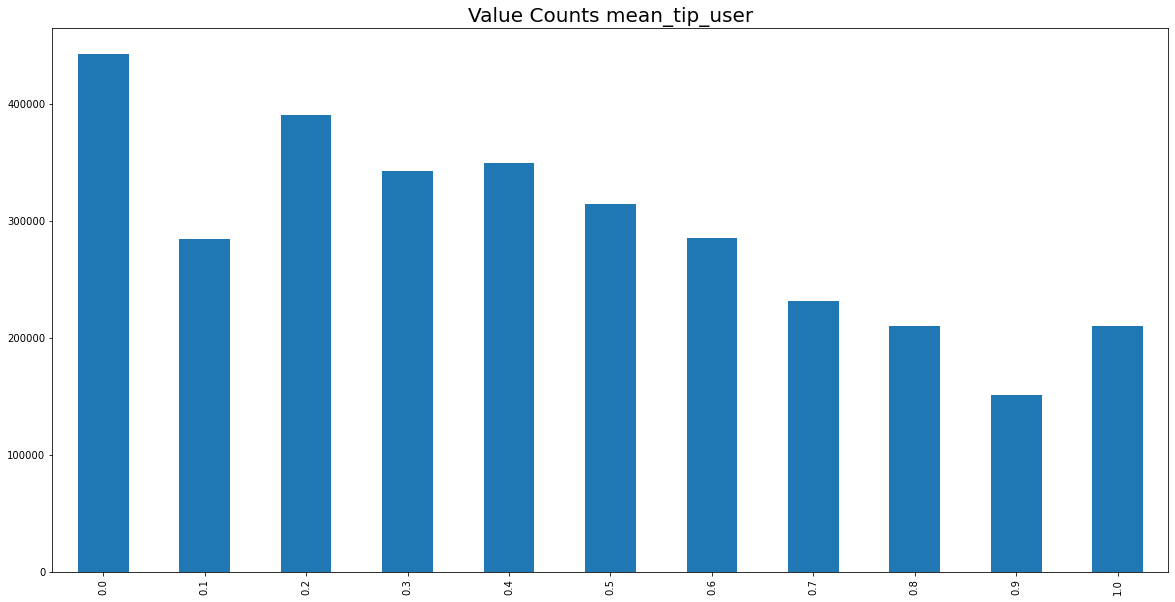

In [122]:
# Get the mean tip value per user
instacart_train['mean_tip_user'] = instacart_train.groupby('user_id')['tip'].transform('mean')
instacart_train['mean_tip_user'] = instacart_train['mean_tip_user'].round(1)

# Maps the mean values to the production set
mean_tip_dict = instacart_train[['user_id', 'mean_tip_user']].set_index('user_id').to_dict()['mean_tip_user']
instacart_prod['mean_tip_user'] = instacart_prod['user_id'].map(mean_tip_dict, na_action='ignore')

plt.figure(figsize=(20, 10))
ax = instacart_train['mean_tip_user'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts mean_tip_user', fontsize = 20)
plt.show()

### created: previous_order_tip
- Numerisches Feature, dass die Information beinhaltet, ob der Nutzer in der vorherigen Bestellung einen tip gegeben hat.

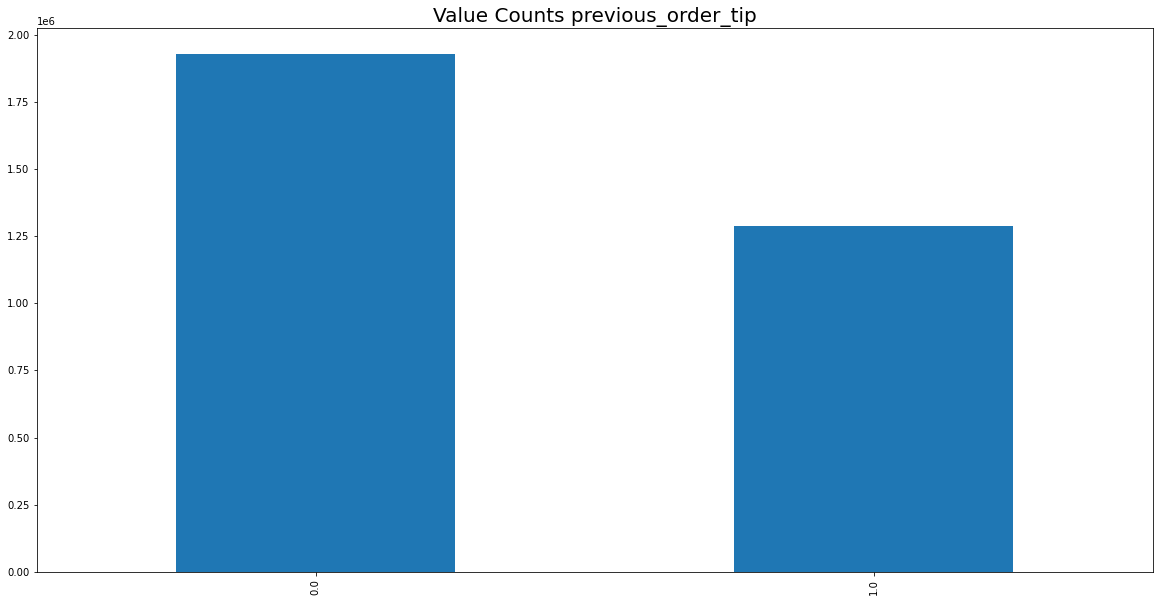

In [123]:
instacart_prod = pd.concat([instacart_train, instacart_prod], ignore_index=True)
# Order the dataframe by user_id and order_number
instacart_train = instacart_train.sort_values(['user_id', 'order_number'], ascending = [True, True])
instacart_prod = instacart_prod.sort_values(['user_id', 'order_number'], ascending = [True, True])

# Shift the value previous tips per user and fill Nans with 0s
# 1st-Previous
instacart_train['previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(1)
instacart_train['previous_order_tip'] = instacart_train['previous_order_tip'].fillna(0)
instacart_prod['previous_order_tip'] = instacart_prod.groupby('user_id')['tip'].shift(1)
instacart_prod['previous_order_tip'] = instacart_prod['previous_order_tip'].fillna(0)
# 2nd-Previous
instacart_train['2_previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(2)
instacart_train['2_previous_order_tip'] = instacart_train['2_previous_order_tip'].fillna(0)
instacart_prod['2_previous_order_tip'] = instacart_prod.groupby('user_id')['tip'].shift(2)
instacart_prod['2_previous_order_tip'] = instacart_prod['2_previous_order_tip'].fillna(0)
# 3rd-Previous
instacart_train['3_previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(3)
instacart_train['3_previous_order_tip'] = instacart_train['3_previous_order_tip'].fillna(0)
instacart_prod['3_previous_order_tip'] = instacart_prod.groupby('user_id')['tip'].shift(3)
instacart_prod['3_previous_order_tip'] = instacart_prod['3_previous_order_tip'].fillna(0)

# Mean 3-Previous
instacart_train['3_previous_tip_user'] = (instacart_train['previous_order_tip'] + instacart_train['2_previous_order_tip'] + instacart_train['3_previous_order_tip']) / 3
instacart_train['3_previous_tip_user'].round(1)

instacart_prod['3_previous_tip_user'] = (instacart_prod['previous_order_tip'] + instacart_prod['2_previous_order_tip'] + instacart_prod['3_previous_order_tip']) / 3
instacart_prod['3_previous_tip_user'].round(1)

# Drop unneded rows / columns
instacart_train = instacart_train.drop(columns=['3_previous_order_tip', '2_previous_order_tip'])
instacart_prod = instacart_prod.drop(columns=['3_previous_order_tip', '2_previous_order_tip'])
instacart_prod = instacart_prod.drop(instacart_prod[instacart_prod['eval_set'] == 'prior'].index)

plt.figure(figsize=(20, 10))
ax = instacart_train['previous_order_tip'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts previous_order_tip', fontsize = 20)
plt.show()

### created: 3_previous_order_tip
- Numerisches Feature, welches die Information beinhaltet, in welchen der 3 vorherigen Bestellung der Nutzer einen tip gegeben hat.

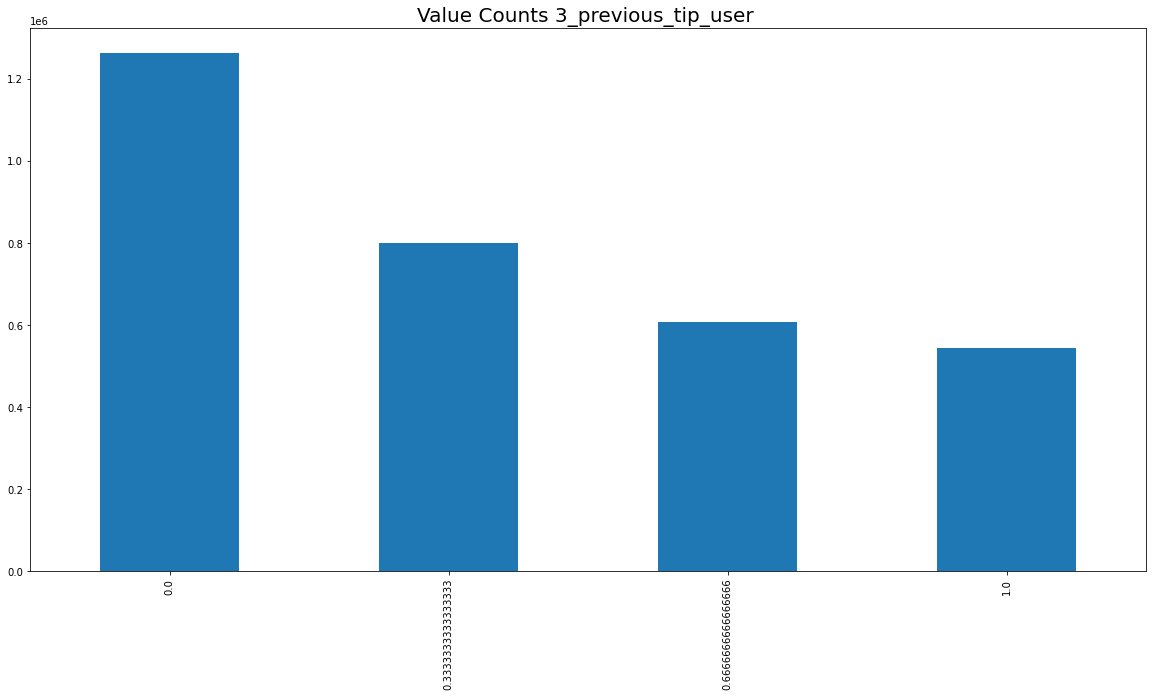

In [124]:
plt.figure(figsize=(20, 10))
ax = instacart_train['3_previous_tip_user'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts 3_previous_tip_user ', fontsize = 20)
plt.show()

### created: mean_days_since_prior_oder_by_user
- Numerisches Feature mit der Information über die durschnittlich vergangenen Tage seit der vorherigen Bestellung pro Nutzer.

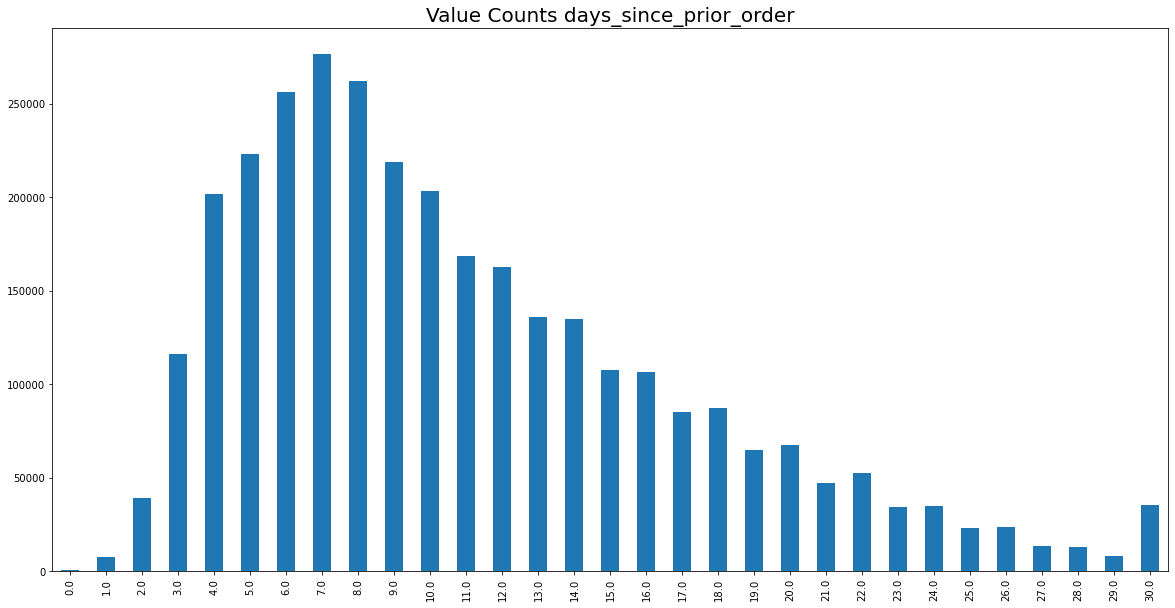

In [125]:
instacart_train['mean_days_since_prior_oder_by_user'] = instacart_train.groupby('user_id')['days_since_prior_order'].transform('mean')
instacart_train['mean_days_since_prior_oder_by_user'] = instacart_train['mean_days_since_prior_oder_by_user'].round(0)

# Maps the mean values to the production set
mean_days_dict = instacart_train[['user_id', 'mean_days_since_prior_oder_by_user']].set_index('user_id').to_dict()['mean_days_since_prior_oder_by_user']
instacart_prod['mean_days_since_prior_oder_by_user'] = instacart_prod['user_id'].map(mean_days_dict, na_action='ignore')

plt.figure(figsize=(20, 10))
ax = instacart_train['mean_days_since_prior_oder_by_user'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts days_since_prior_order', fontsize = 20)
plt.show()

### created: weeks_since_prior_order
- Numerisches Feature mit der Information über die vergangenen Wochen seit der letzten Bestellung.

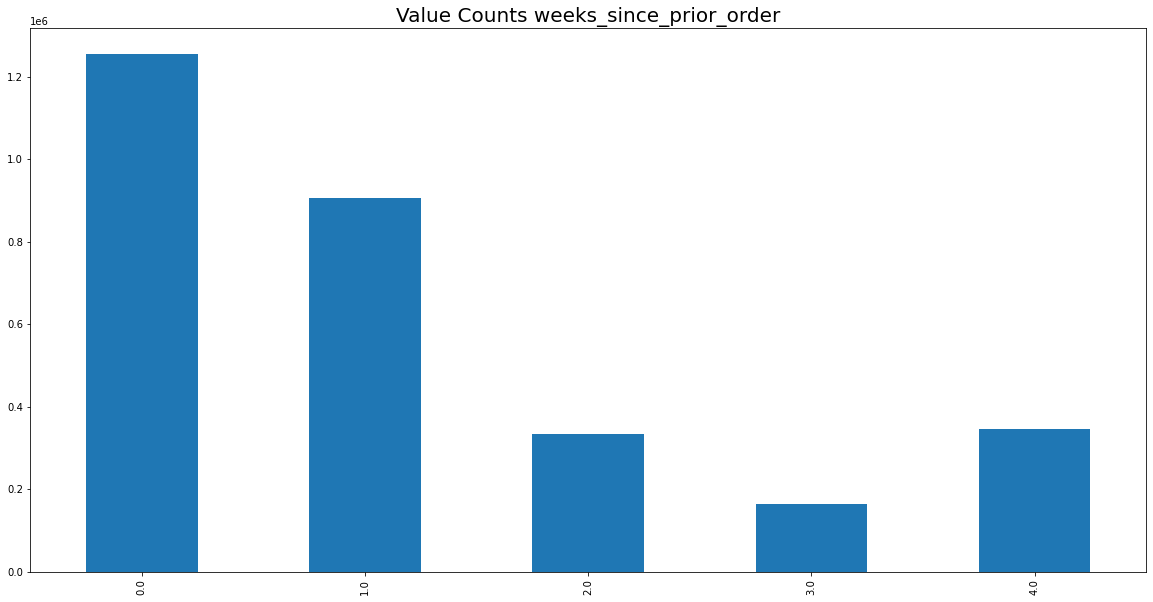

In [126]:
instacart_train['weeks_since_prior_order'] = instacart_train['days_since_prior_order'] // 7
instacart_prod['weeks_since_prior_order'] = instacart_prod['days_since_prior_order'] // 7

plt.figure(figsize=(20, 10))
ax = instacart_train['weeks_since_prior_order'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts weeks_since_prior_order', fontsize = 20)
plt.show()

### created: amount_ordered_products
- Numerisches Features mit der Information über die Anzahl der Prdukte, welche in der Bestellung enthalten waren. Der Wert ergibt sich aus dem Count-Aggreget über die Order ID auf der Order Products Tabelle.
- Am häufigsten werden 10 Produkte gleichzeitig bestellt.

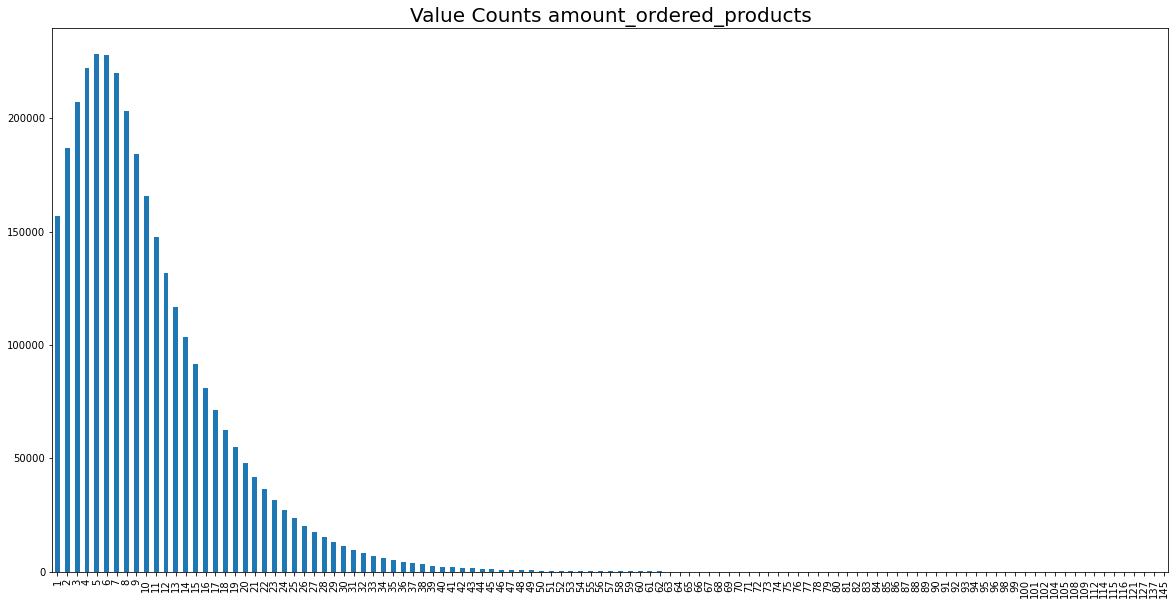

In [127]:
opp['amount_ordered_products'] = opp.groupby('order_id')['product_id'].transform('count')
amount_ordered_products = opp.groupby('order_id').head(1)
instacart_train = instacart_train.merge(amount_ordered_products[['order_id', 'amount_ordered_products']], left_on='order_id', right_on='order_id')
instacart_train['amount_ordered_products'] = instacart_train['amount_ordered_products'].astype('int16')

instacart_prod = instacart_prod.merge(amount_ordered_products[['order_id', 'amount_ordered_products']], left_on='order_id', right_on='order_id')
instacart_prod['amount_ordered_products'] = instacart_prod['amount_ordered_products'].astype('int16')

plt.figure(figsize=(20, 10))
ax = instacart_train['amount_ordered_products'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts amount_ordered_products', fontsize = 20)
plt.show()

### created: amount_reordered_products
- Numerisches Features mit der Information über die Anzahl der wiederbestellten Produkte, welche in der Bestellung enthalten waren. Der Wert ergibt sich aus dem Summen-Aggreget über die reordered-Information auf der Order Products Tabelle.

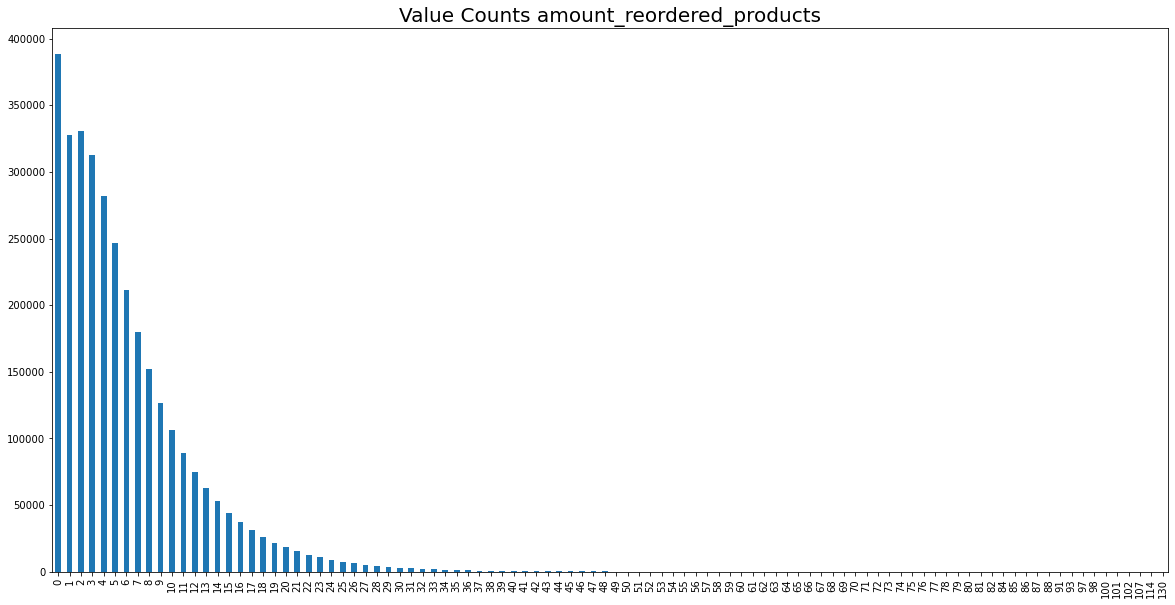

In [128]:
opp['amount_reordered_products'] = opp.groupby('order_id')['reordered'].transform('sum')
amount_reordered_products = opp.groupby('order_id').head(1)
instacart_train = instacart_train.merge(amount_reordered_products[['order_id', 'amount_reordered_products']], left_on='order_id', right_on='order_id')
instacart_train['amount_reordered_products'] = instacart_train['amount_reordered_products'].astype('int16')

instacart_prod = instacart_prod.merge(amount_reordered_products[['order_id', 'amount_reordered_products']], left_on='order_id', right_on='order_id')
instacart_prod['amount_reordered_products'] = instacart_prod['amount_reordered_products'].astype('int16')

plt.figure(figsize=(20, 10))
ax = instacart_train['amount_reordered_products'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts amount_reordered_products', fontsize = 20)
plt.show()

### created: factor_reordered_products
- Numerisches Features mit der Information über Anteil der wiederbestellen Produkte in einer Bestellung. Der Wert ergibt sich aus dem Verhältnis der zuvor erstellen Features.

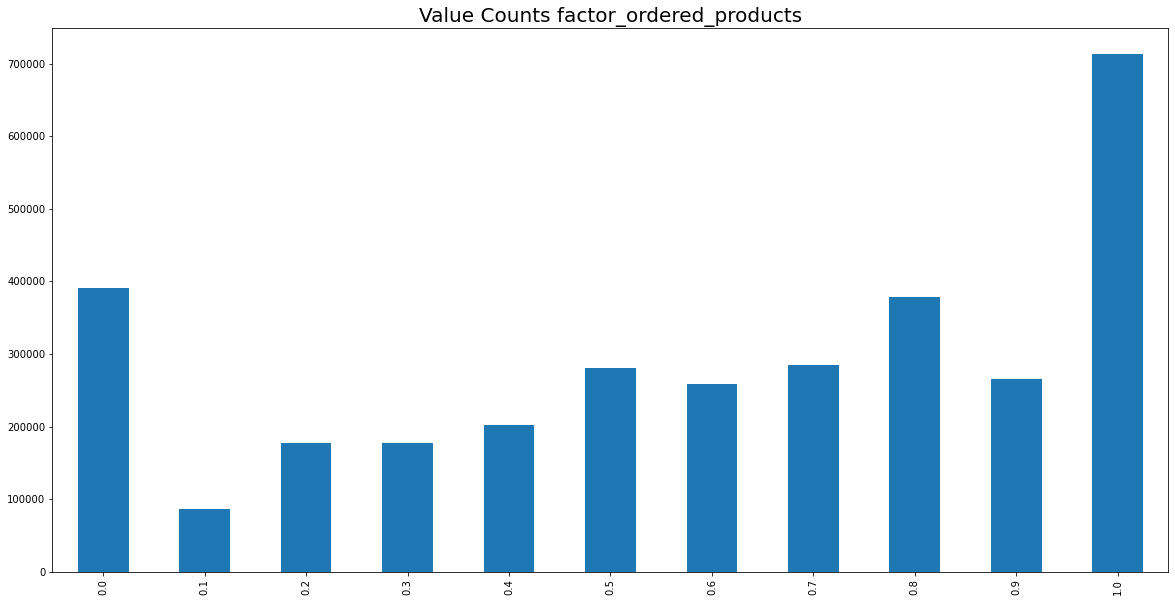

In [129]:
instacart_train['factor_reordered_products'] = instacart_train['amount_reordered_products'] / instacart_train['amount_ordered_products']
instacart_train['factor_reordered_products'] = instacart_train['factor_reordered_products'].round(1)

instacart_prod['factor_reordered_products'] = instacart_prod['amount_reordered_products'] / instacart_prod['amount_ordered_products']
instacart_prod['factor_reordered_products'] = instacart_prod['factor_reordered_products'].round(1)

plt.figure(figsize=(20, 10))
ax = instacart_train['factor_reordered_products'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts factor_ordered_products', fontsize = 20)
plt.show()

## Daten verstehen
In dem folgenden Abschnitt werden interpretierbare Ergebnisse generiert, von welchen Faktoren es abhängt, ob Trinkgeld gegeben wird.

In [130]:
instacart_train.describe()

,order_id,tip,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisles_1 prepared soups salads,aisles_2 specialty cheeses,aisles_3 energy granola bars,...,departments_20 deli,departments_21 missing,mean_tip_user,previous_order_tip,3_previous_tip_user,mean_days_since_prior_oder_by_user,weeks_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3008665.0,3.214874e+06,3214874.0,3214874.0,...,3214874.0,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3214874.0,3008665.0,3.214874e+06,3.214874e+06,3.214874e+06
mean,1.710827e+06,4.217627e-01,1.029701e+05,1.719107e+01,2.776364e+00,1.344347e+01,NaN,1.962280e-02,NaN,NaN,...,NaN,1.847839e-02,4.214956e-01,4.001861e-01,3.785700e-01,NaN,NaN,1.008888e+01,5.949389e+00,5.995255e-01
std,9.875206e+05,4.938411e-01,5.953411e+04,1.779950e+01,2.041806e+00,4.226246e+00,0.0,1.389160e-01,0.0,0.0,...,0.0,1.346436e-01,3.038129e-01,4.899360e-01,3.713585e-01,0.0,0.0,7.525398e+00,5.842059e+00,3.408452e-01
min,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.556832e+05,0.000000e+00,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.0,0.000000e+00,0.0,0.0,...,0.0,0.000000e+00,2.000000e-01,0.000000e+00,0.000000e+00,6.0,0.0,5.000000e+00,2.000000e+00,3.000000e-01
50%,1.711120e+06,0.000000e+00,1.026620e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.0,0.000000e+00,0.0,0.0,...,0.0,0.000000e+00,4.000000e-01,0.000000e+00,3.333333e-01,10.0,1.0,8.000000e+00,4.000000e+00,7.000000e-01
75%,2.566034e+06,1.000000e+00,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,15.0,0.000000e+00,0.0,0.0,...,0.0,0.000000e+00,7.000000e-01,1.000000e+00,6.666667e-01,15.0,2.0,1.400000e+01,8.000000e+00,9.000000e-01
max,3.421083e+06,1.000000e+00,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,30.0,1.000000e+00,1.0,1.0,...,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,30.0,4.0,1.450000e+02,1.300000e+02,1.000000e+00


### User zu tip
- Je höher die durchschnittliche tip-Wahrscheinlichkeit des Nutzers ist, dest höher ist die Wahrscheinlichkeit, dass er auch bei der vorliegenden Bestellung einen tip geben hat.
- Auch bei der Betrachtung der (1 bzw. 3) direkt zuvor erfolgen Bestellung. ist eine Korrelation der vorherigen tips mit der tip-Wahrscheinlichkeit für die vorliegende Bestellung wahrscheinlich. 

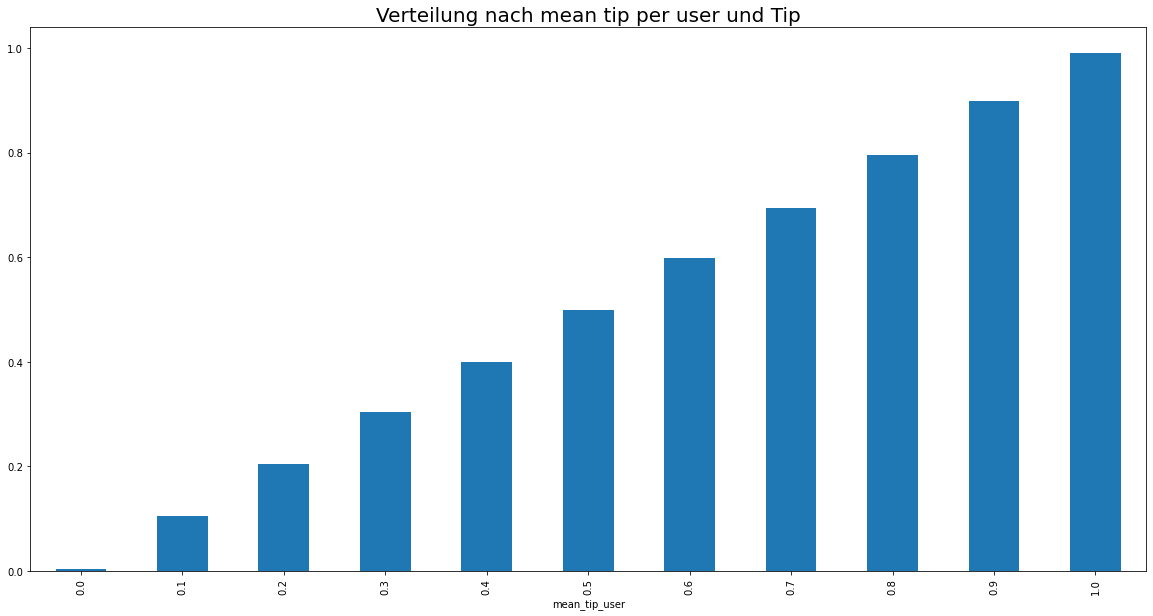

In [131]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('mean_tip_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach mean tip per user und Tip', fontsize = 20)
plt.show()

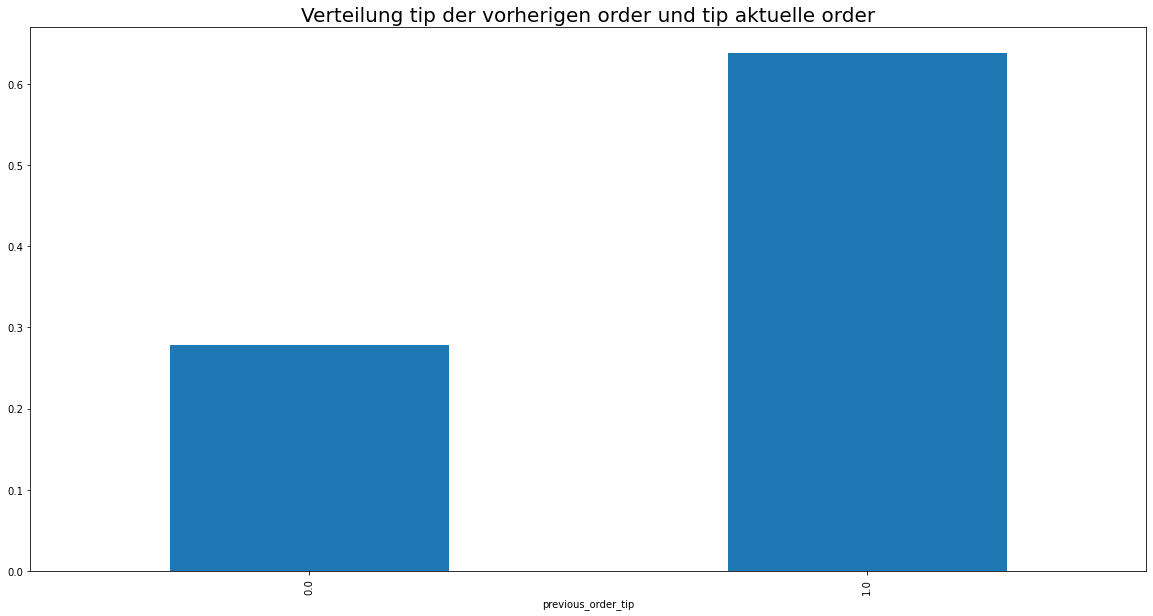

In [132]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('previous_order_tip').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung tip der vorherigen order und tip aktuelle order', fontsize = 20)
plt.show()

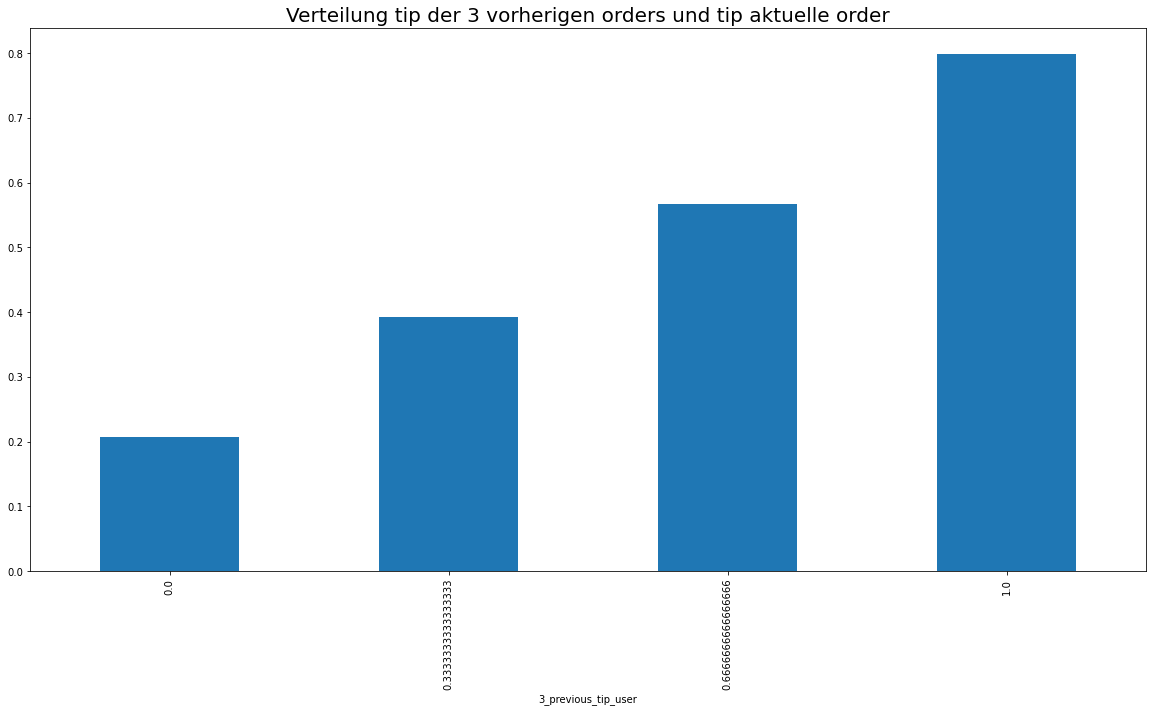

In [133]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('3_previous_tip_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung tip der 3 vorherigen orders und tip aktuelle order', fontsize = 20)
plt.show()

### Day of week zu tip
- Samstag und Sonntag ist die Wahrscheinlichkeit, dass ein tip gegeben wird, um ca. 0,1 höher. Der Unterschied ist statistisch signifikant, da für alle Ausprägungen ausreichend Beobachtungen vorliegen.

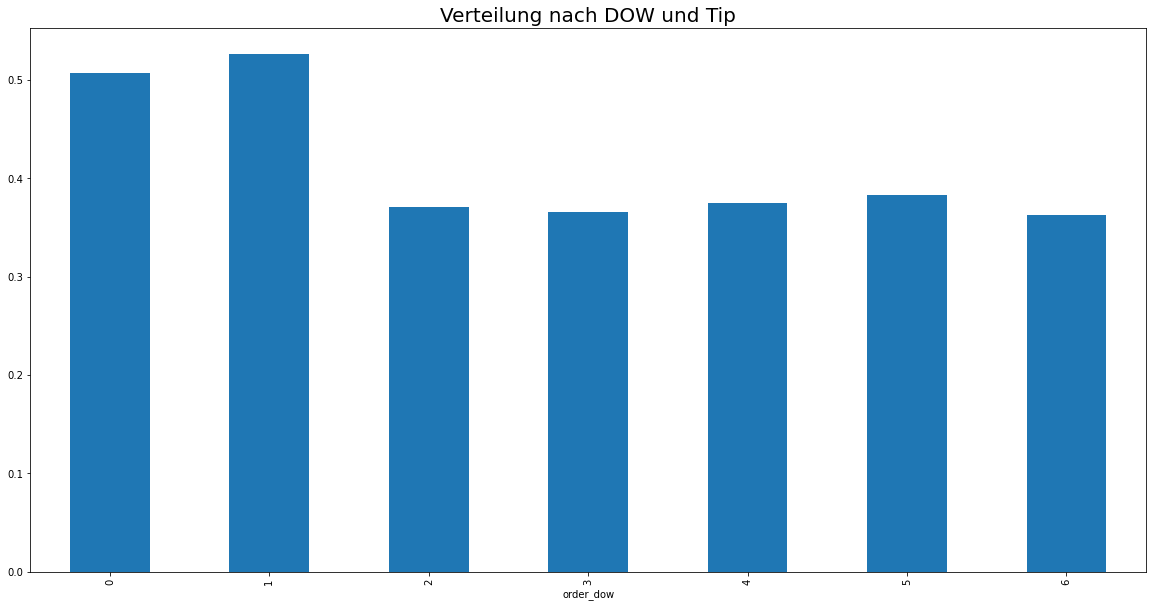

In [134]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_dow').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach DOW und Tip', fontsize = 20)
plt.show()

### Hour of day zu tip
- Zwischen 19 Uhr und 4 Uhr scheint die Wahrscheinlichkeit, dass ein tip gegegeben wird, um ca. 0,1 höher. Ca. 14% der Bestellungen fallen in diesen Zeitraum. Somit scheint der Unterschied auch statistisch signifikant zu sein.

Ca. 13.955476948707787% der Bestellungen wurden in zwischen 19 und 4 Uhr aufgegeben.


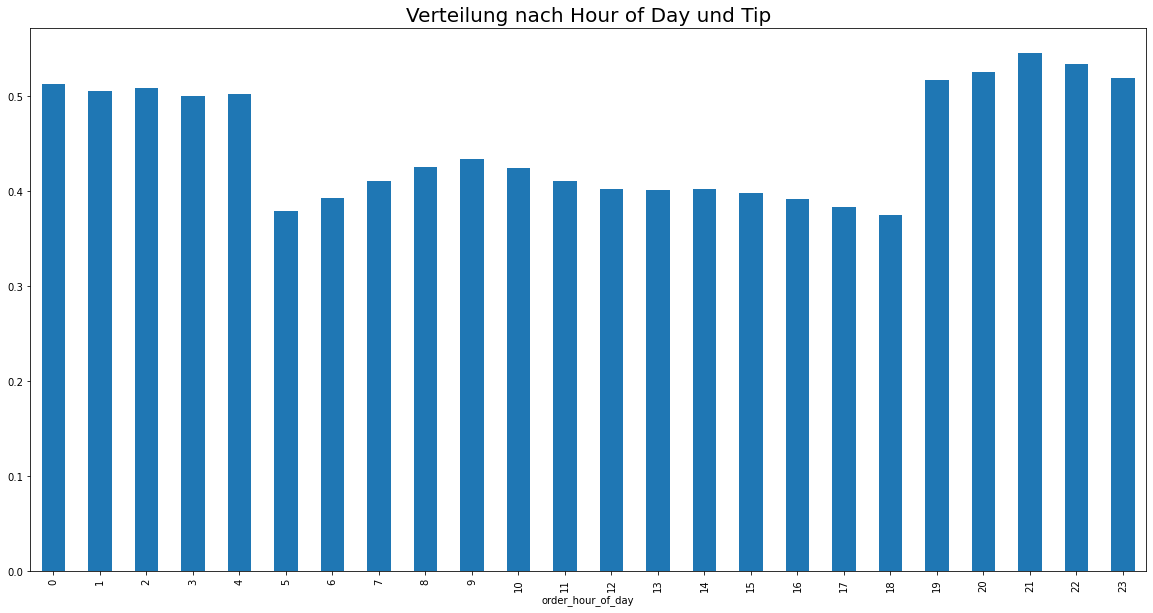

In [135]:
night_percentage = len(instacart_train[(instacart_train['order_hour_of_day'] < 5) | (instacart_train['order_hour_of_day'] > 18)]) / len(instacart_train)
print(f'Ca. {night_percentage*100}% der Bestellungen wurden in zwischen 19 und 4 Uhr aufgegeben.')
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_hour_of_day').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Hour of Day und Tip', fontsize = 20)
plt.show()

### Days since prior order zu tip

- Aufwärtstrend in der ersten Woche an den Tagen 1-7 erkennbar.
- Erste Trendkomponente: Statistisch signifikanter Abwärtstrend hinsichtlich der tip-Wahrscheinlichkeit ab Beginn der zweiten Woche. (Siehe Abbildung Verteilung nach Weeks since prior order und tip)
- Zweite Trendkomponente: Statistisch signifkant höherer tip-Wahrscheinlichkeit, wenn relativ gesehen wieder an denselben Wochentagen bestellt wird (Erste Bestellung Dienstags, zweite Bestellung Dienstags). Dagegen deutlich geringere tip-Wahrscheinlichkeit, wenn zwei Wochentage später die nächste Bestellung erfolgt (Erste Bestellung Dienstags, zweite Bestellung Donnerstags) (Siehe Abbildung Verteilung nach relative day since prior order und tip)

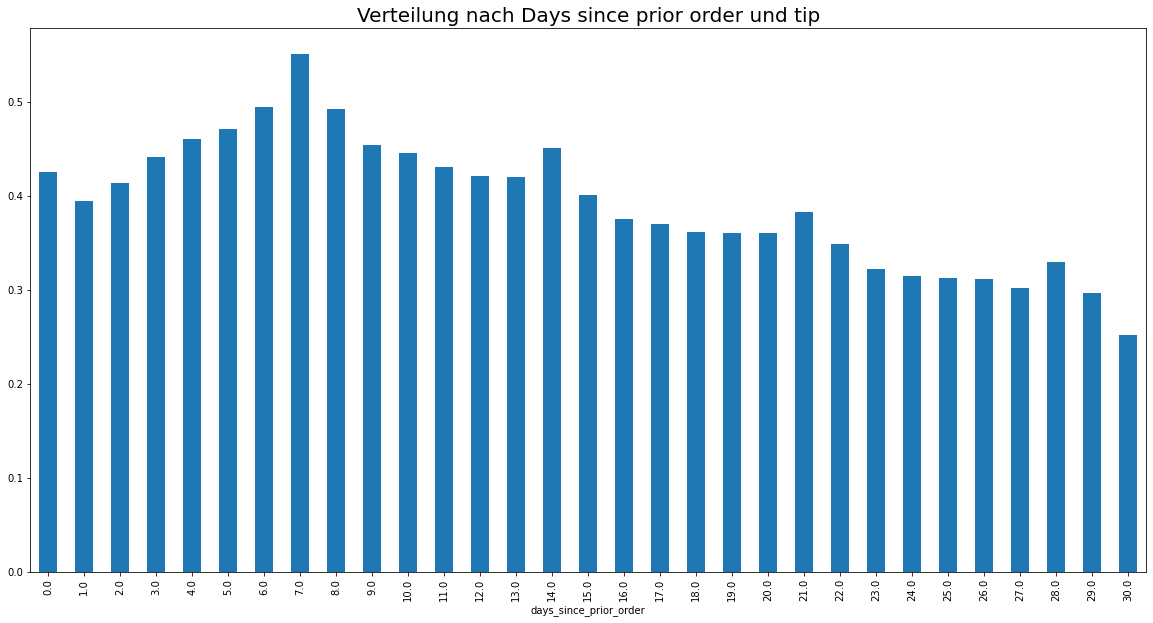

In [136]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('days_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Days since prior order und tip', fontsize = 20)
plt.show()

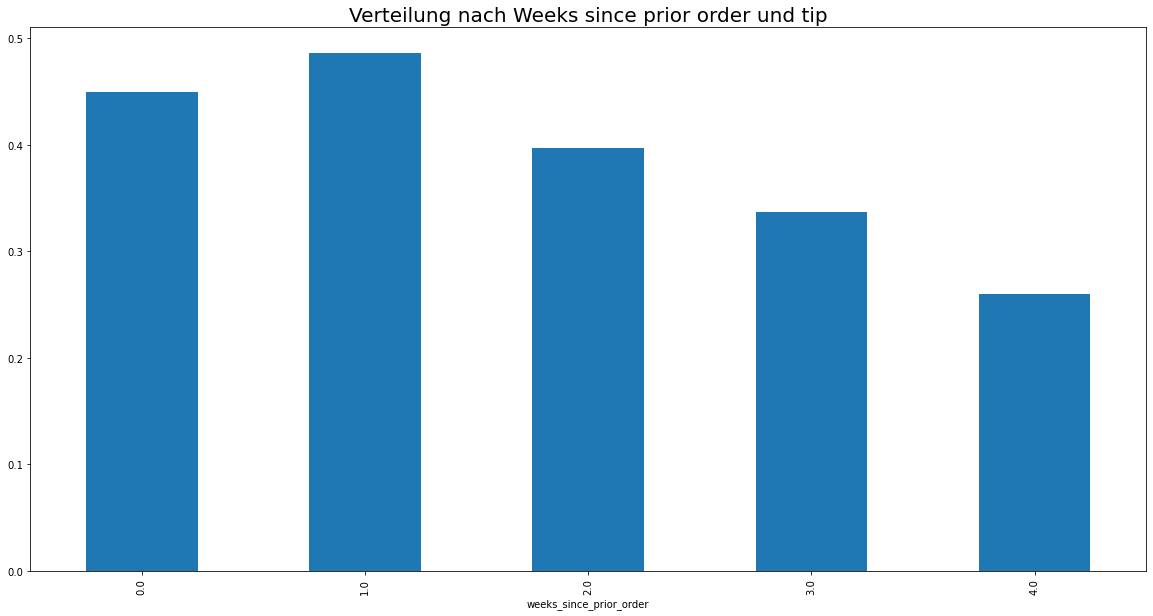

In [137]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('weeks_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Weeks since prior order und tip', fontsize = 20)
plt.show()

### Mean days since prior order per User zu tip
- Nutzer, die im Durschnitt nach 0 bis 7 Tagen erneut bestellen haben eine stark steigende tip-Wahrscheinlichkeit.
- Die höchste tip-Wahrscheinlichkeit haben Nutzer, die durchschnittlichen nach genau 7 Tagen erneut bestellen.
- Nutzer, die im Durchscnitt mehr nach mehr als 7 Tagen erneut bestellen, haben eine sinkende tip-Wahrscheinlichkeit.

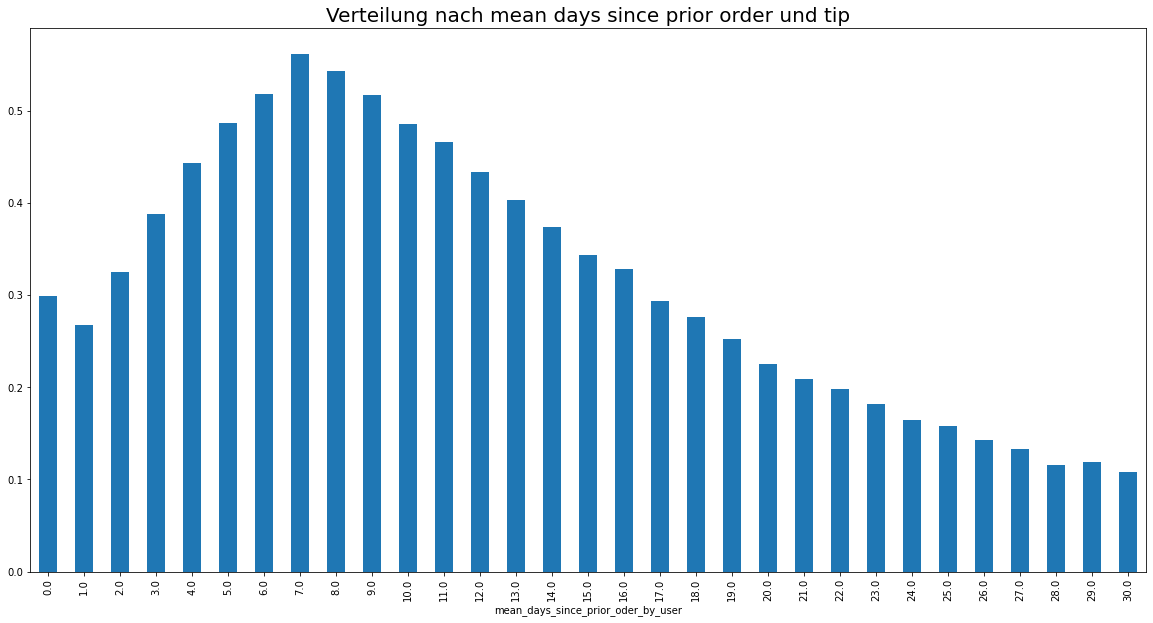

In [138]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('mean_days_since_prior_oder_by_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach mean days since prior order und tip', fontsize = 20)
plt.show()

### Order number zu tip
- Mit der Anzahl der Bestellungen nimmt die tip-Wahrscheinlichkeit zunächst stetig zu. 
- Die höchste tip-Wahrscheinlichkeit kann für die Nutzer bei der 35. Bestellung beobachtet werden. Bei ca. 52% der 35. Bestellungen wurde ein tip gegeben.
- Bei mehr als 35 Bestellungen beginnt die tip-Wahrscheinlichkeit wieder zu sinken. Je höher die Anzahl der Bestellungen, desto weniger Beobachtungen liegen für vor. Dennoch sind die Trends signifikant.

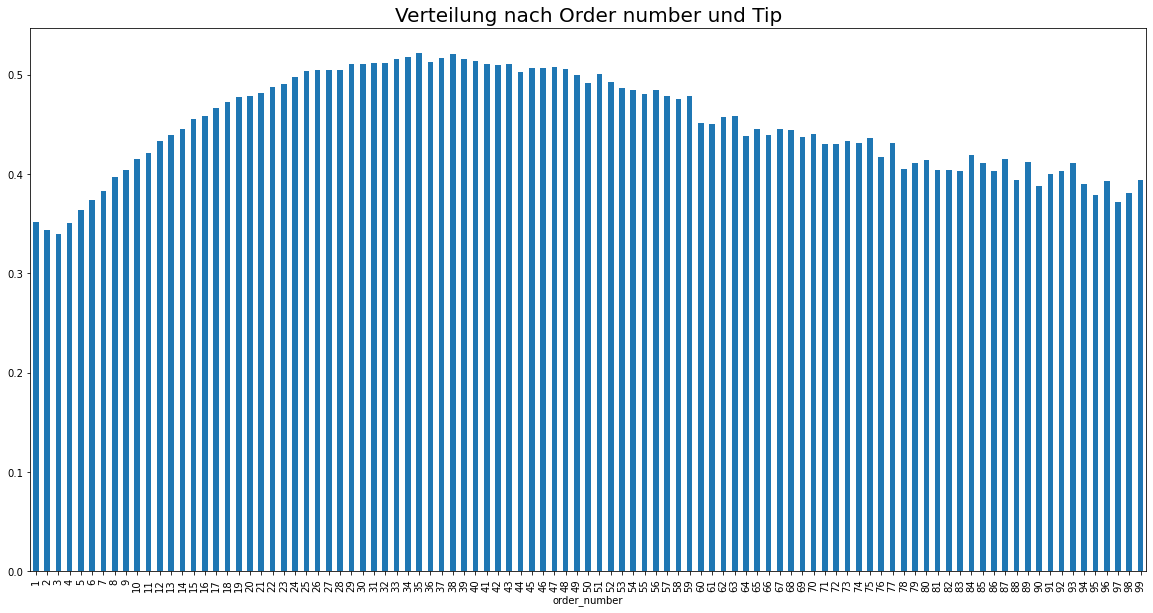

In [139]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_number').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Order number und Tip', fontsize = 20)
plt.show()

### Amount of ordered products zu tip
- Mit der Anzahl der bestellten Produkte nimmt die tip-Wahrscheinlichkeit zunächst zu.
- Mit zunehmender Anzahl der bestellten Proudkte nimmt die Aussagefähigkeit der Grafik ab, da zu wenige Daten über sehr große Bestellungen im Datensatz enthalten sind. Die großen Schwankungen am oberen Ende der Anzahl bestellter Produkte sind somit nicht signifikant.

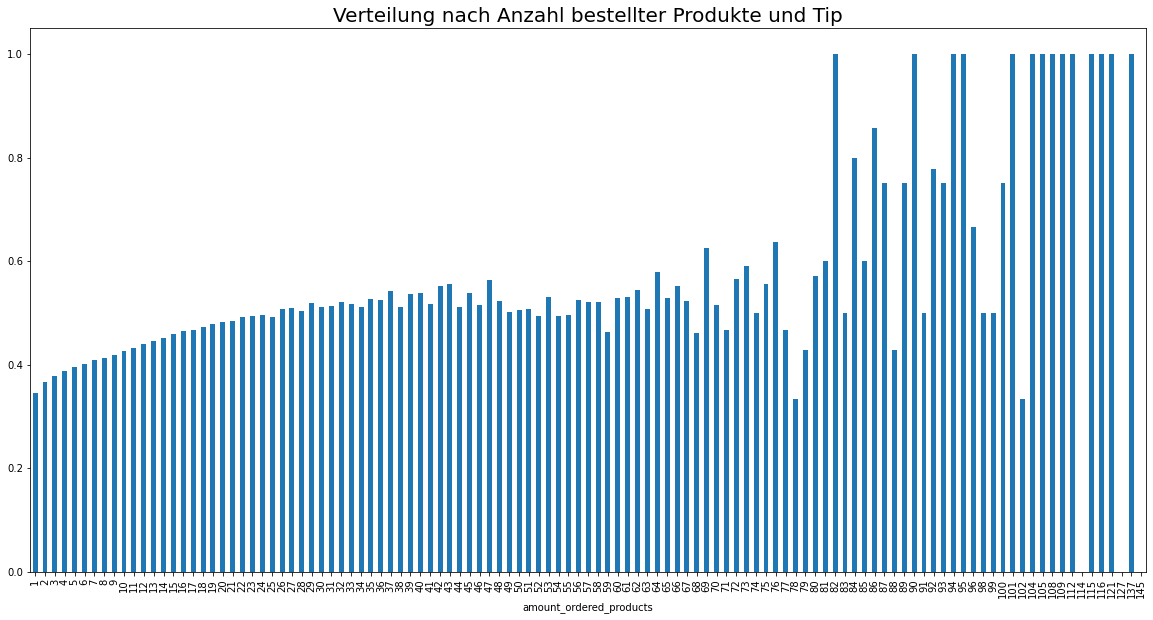

In [140]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('amount_ordered_products').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Anzahl bestellter Produkte und Tip', fontsize = 20)
plt.show()

### Amount of reordered products zu tip
- Mit der Anzahl der wiederbestellten Produkte nimmt die tip-Wahrscheinlichkeit zunächst zu.
- Mit zunehmender Anzahl der wiederbestellten Proudkte nimmt die Aussagefähigkeit der Grafik ab, da zu wenige Daten über sehr große Bestellungen im Datensatz enthalten sind. Die großen Schwankungen am oberen Ende der Anzahl bestellter Produkte sind somit nicht signifikant.

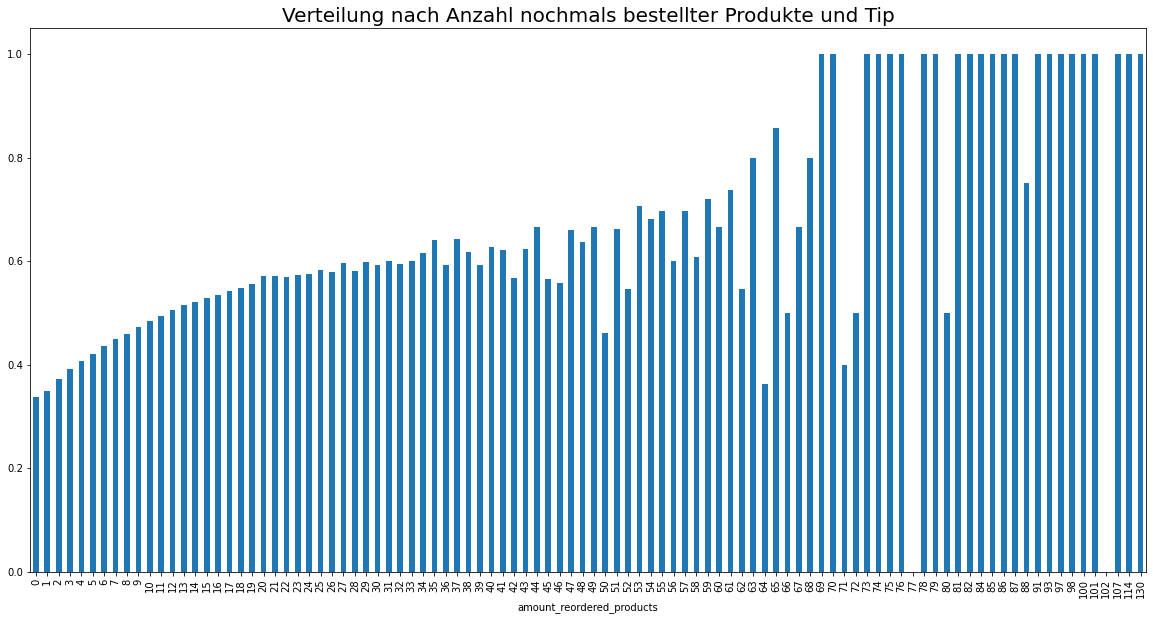

In [141]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('amount_reordered_products').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Anzahl nochmals bestellter Produkte und Tip', fontsize = 20)
plt.show()

### Factor of reordered products zu tip
- Je größer der Anteil der wiederbestellten Produkte an der Bestellung ist, desto größer ist die tip-Wahrscheinlichkeit. Eine Ausnahmen zu diesem Trend ist der Faktor 1.0, bei welchem die tip-Wahrscheinlichkeit wiederrum im Vergleich zum Faktor 0.9 gesunken ist.
- Die Grafik ist für jeden Wert aussagefähig, da für jeden Faktor eine ausreichende Stichprobe vorliegt.

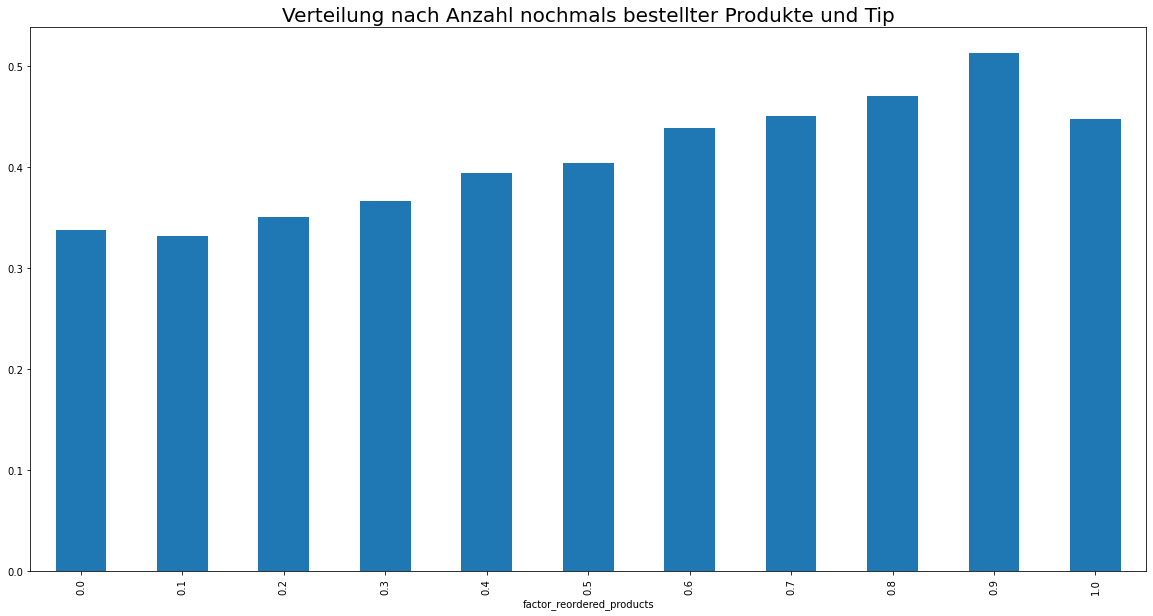

In [142]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('factor_reordered_products').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Anzahl nochmals bestellter Produkte und Tip', fontsize = 20)
plt.show()

### Aisles zu tip
- Die Aisles mit der Beschreibung: "white wines", "spirits", "beers coolers" und "speciality wines champagnes" weisen eine signifikant häufigere tip-Wahrscheinlichkeit auf.

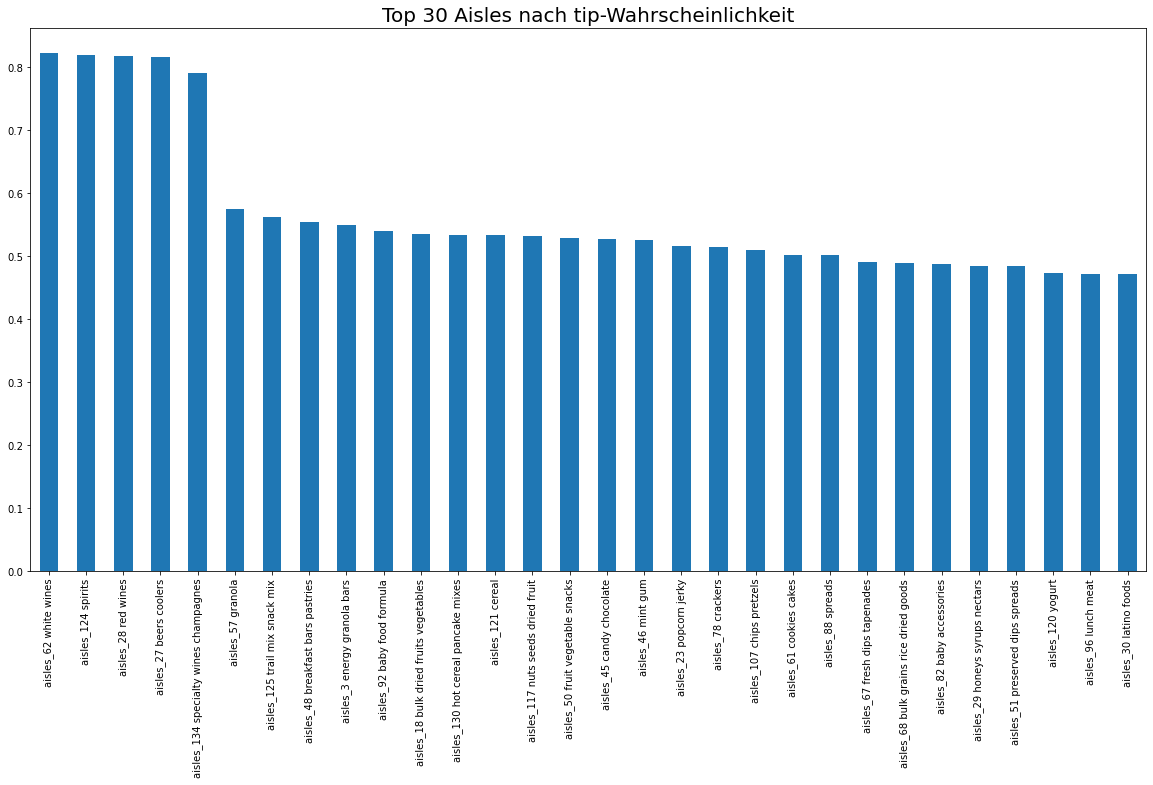

In [143]:
df = pd.DataFrame()
for col in instacart_train_aisles.columns:
    df = pd.concat([df, instacart_train_aisles.groupby(col).tip.mean()], axis=1)
df.set_axis(instacart_train_aisles.columns, axis=1,inplace=True)
ax = df.loc[1,:].drop(index=['tip']).T.sort_values(ascending=False).head(30).plot(kind='bar', figsize=(20,10))
ax.set_title(label = 'Top 30 Aisles nach tip-Wahrscheinlichkeit', fontsize = 20)
plt.show()

### Departements zu tip
- Das Departement mit der Beschreibung: "alcohol" weist eine signifikant häufigere tip-Wahrscheinlichkeit auf. Diese liegt mit ca. 80% deutlich höher als andere tip-Wahrscheinlichkeiten.

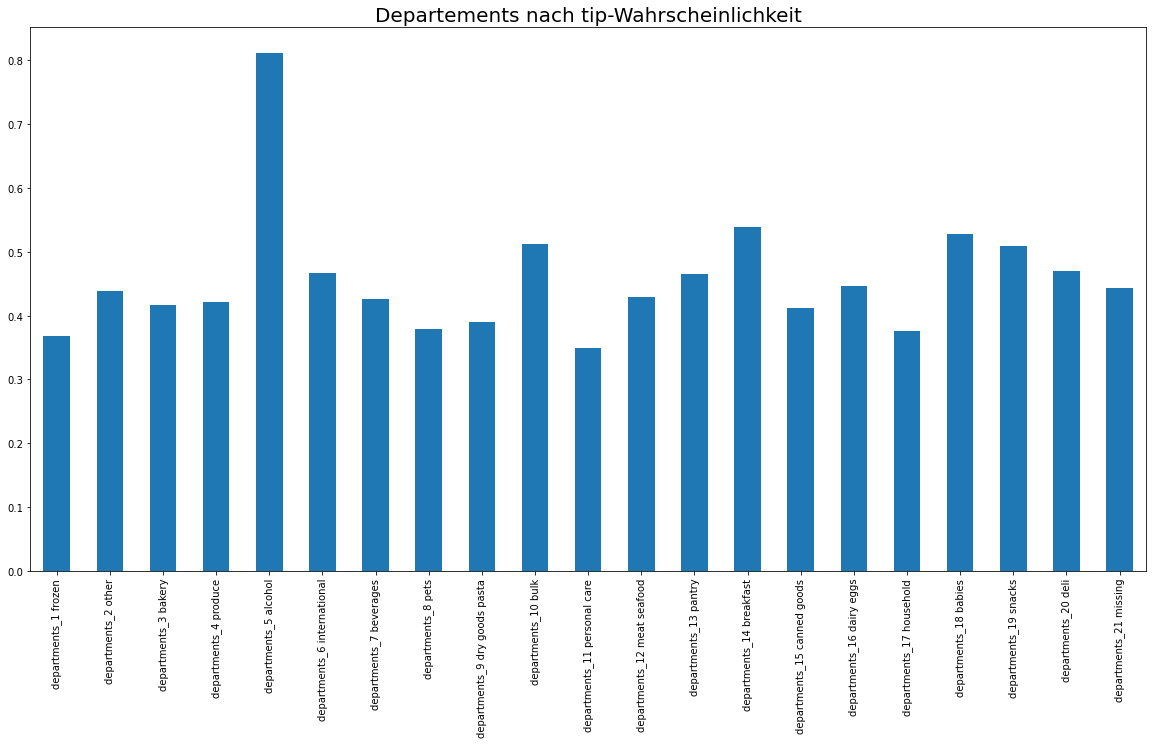

In [144]:
df = pd.DataFrame()
for col in instacart_train_departements.columns:
    df = pd.concat([df, instacart_train_departements.groupby(col).tip.mean()], axis=1)
df.set_axis(instacart_train_departements.columns, axis=1,inplace=True)
ax = df.loc[1,:].drop(index=['tip']).T.plot(kind='bar', figsize=(20,10))
ax.set_title(label = 'Departements nach tip-Wahrscheinlichkeit', fontsize = 20)
plt.show()

## Korrelationen

Mithilfe der Korrelationen werden alle Features auf linearen Zusammenhang mit der tip-Wahrscheinlichkeit geprüft. Allerdings ist diese Metrik nicht besonders aussagekräftig, to nicht-lineare Zusammenhänge nicht erkannt werden.


Korrelationen der Features ohne Aisles und Departements:
- Insbesondere der mean_tip_user, welcher den durchschnittlichen tip pro User beschreibt ist ein sehr aussagekräftiges Features.

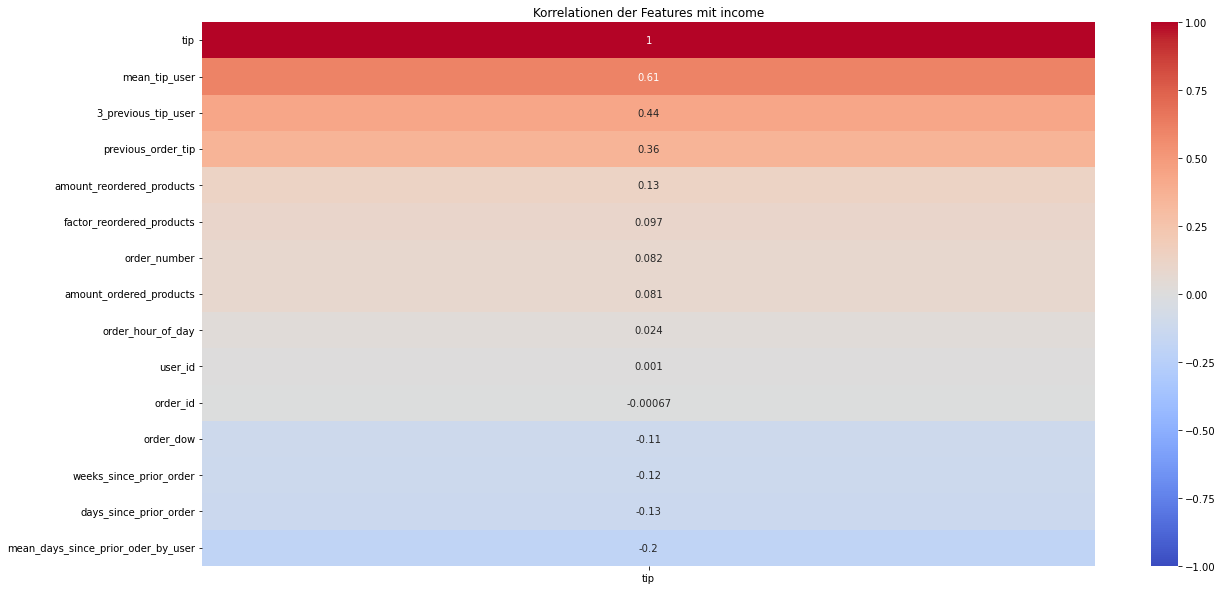

In [145]:
instacart_train_withouth_aisles_and_departements = instacart_train.loc[:,~instacart_train.columns.str.contains('aisles')]
instacart_train_withouth_aisles_and_departements = instacart_train_withouth_aisles_and_departements.loc[:,~instacart_train_withouth_aisles_and_departements.columns.str.contains('departments')]

plt.figure(figsize=(20, 10))
corr_with_income = instacart_train_withouth_aisles_and_departements.corr()[['tip']].sort_values(by='tip', ascending=False)
heatmap = sns.heatmap(corr_with_income, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Korrelationen der Features mit income')
plt.show()

Korrelationen der Aisles:
- Die Korrelationen befinden sich in einem sehr geringen Bereich.

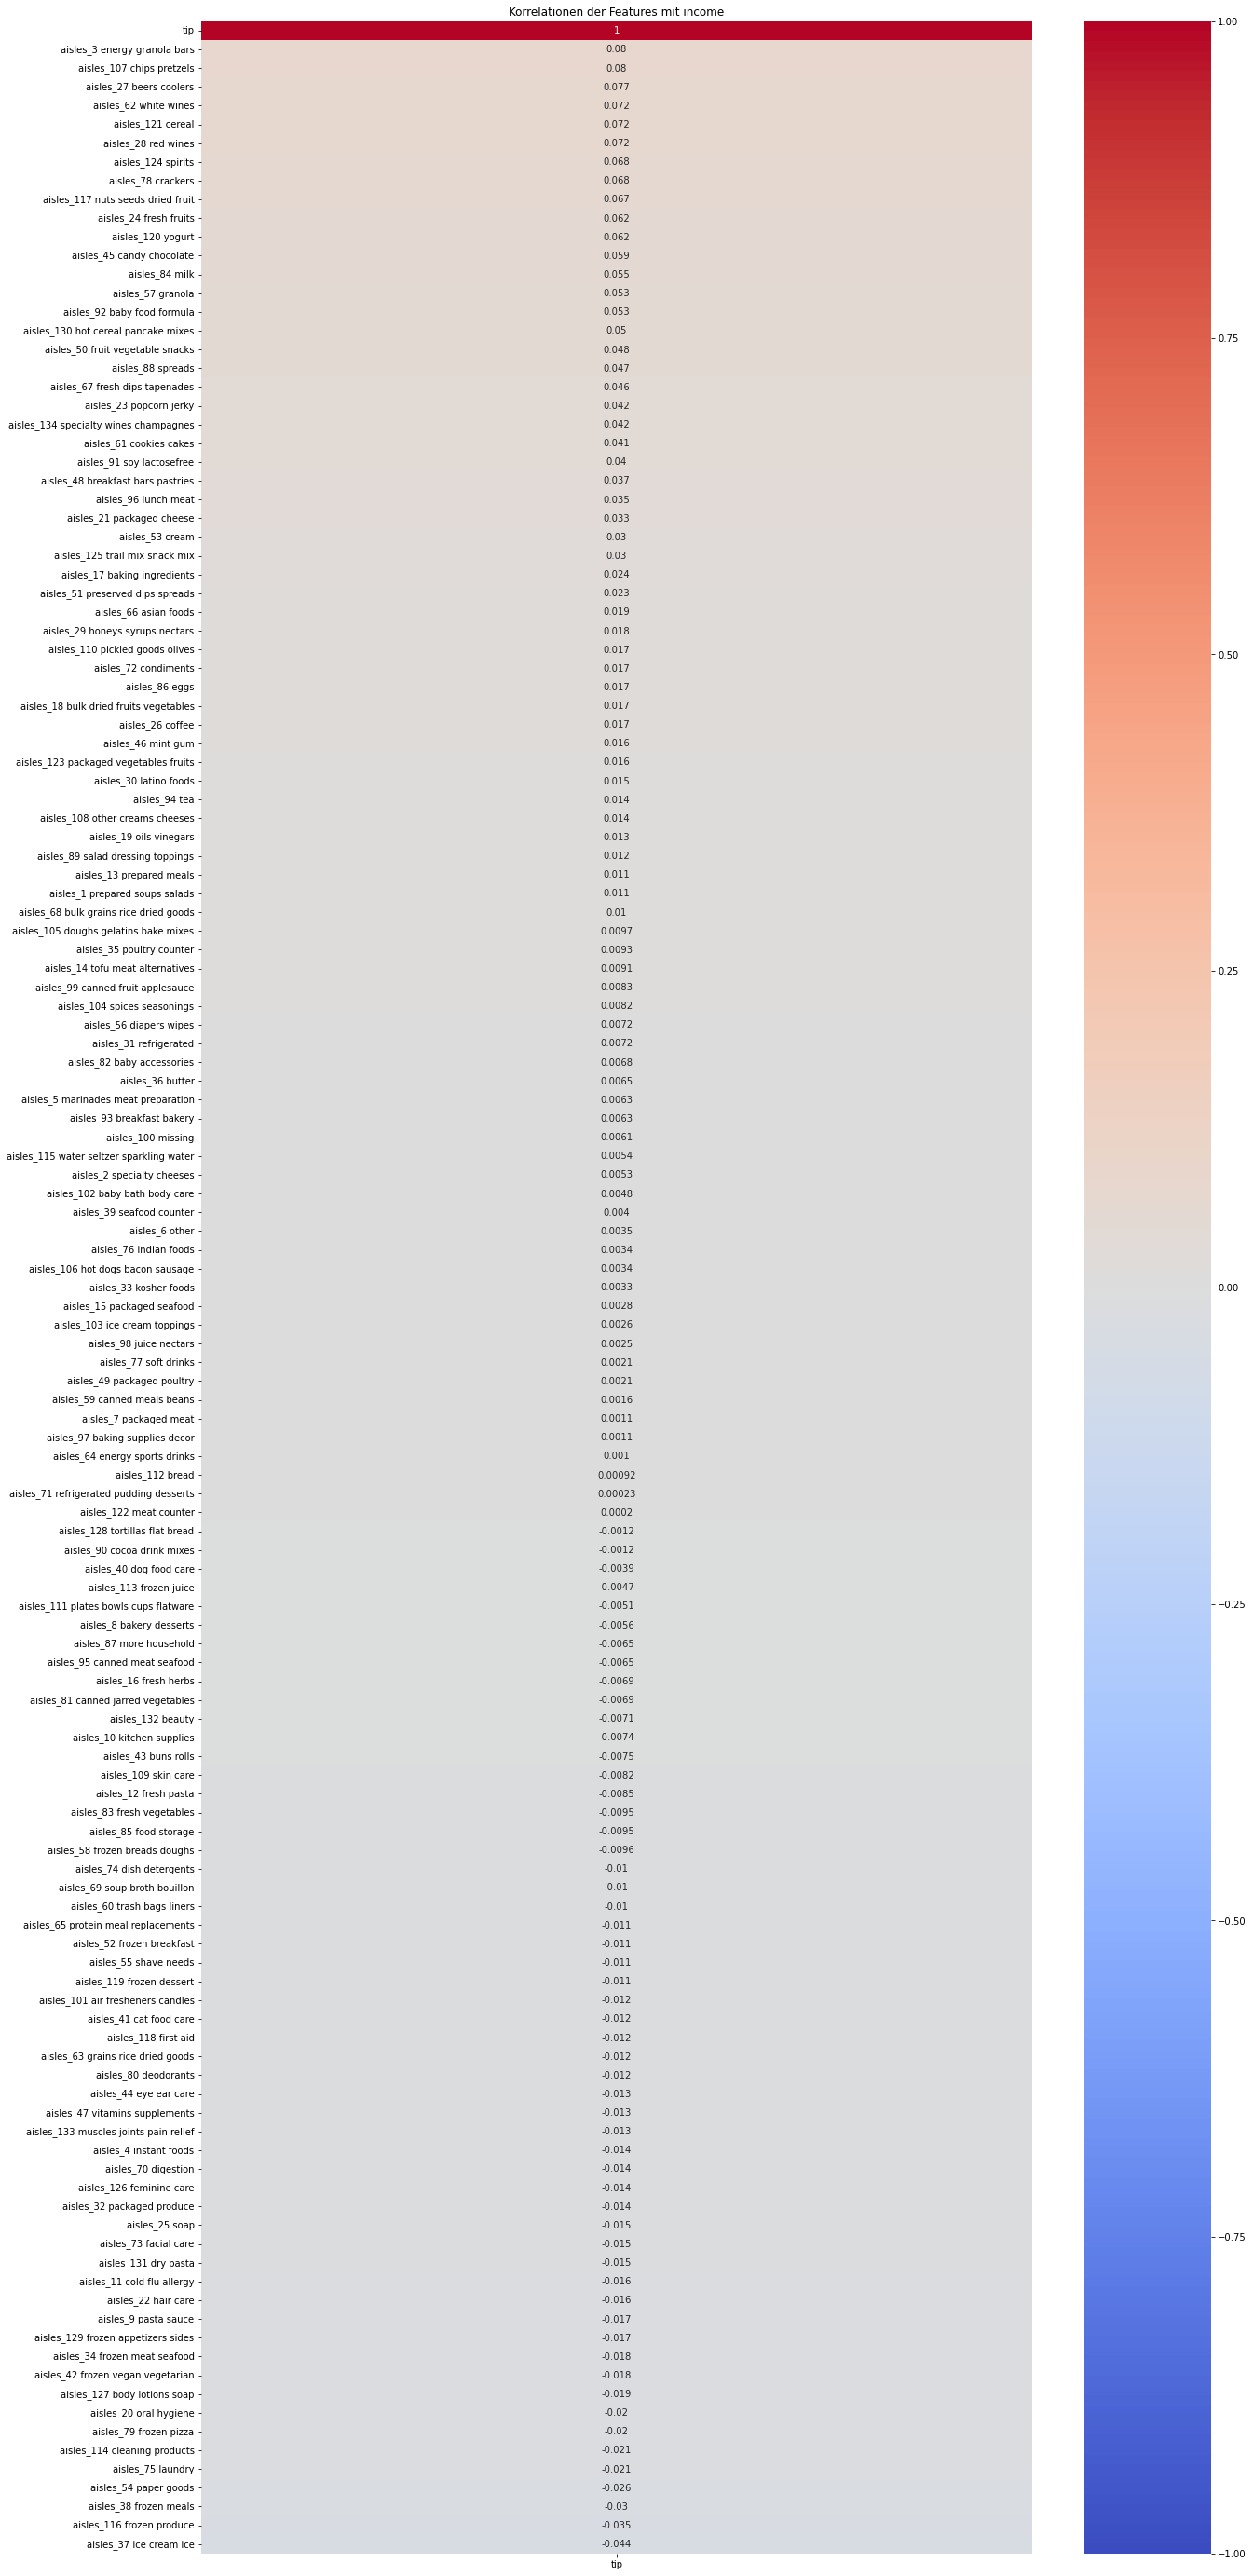

In [146]:
plt.figure(figsize=(20, 50))
corr_with_income = instacart_train_aisles.corr()[['tip']].sort_values(by='tip', ascending=False)
heatmap = sns.heatmap(corr_with_income, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Korrelationen der Features mit income')
plt.show()

Korrelationen der Departements:
- Es ist eine positive Korrelation zwischen Snacks, Alkohol und Breakfast zu der tip-Wahrscheinlichkeit erkennbar.

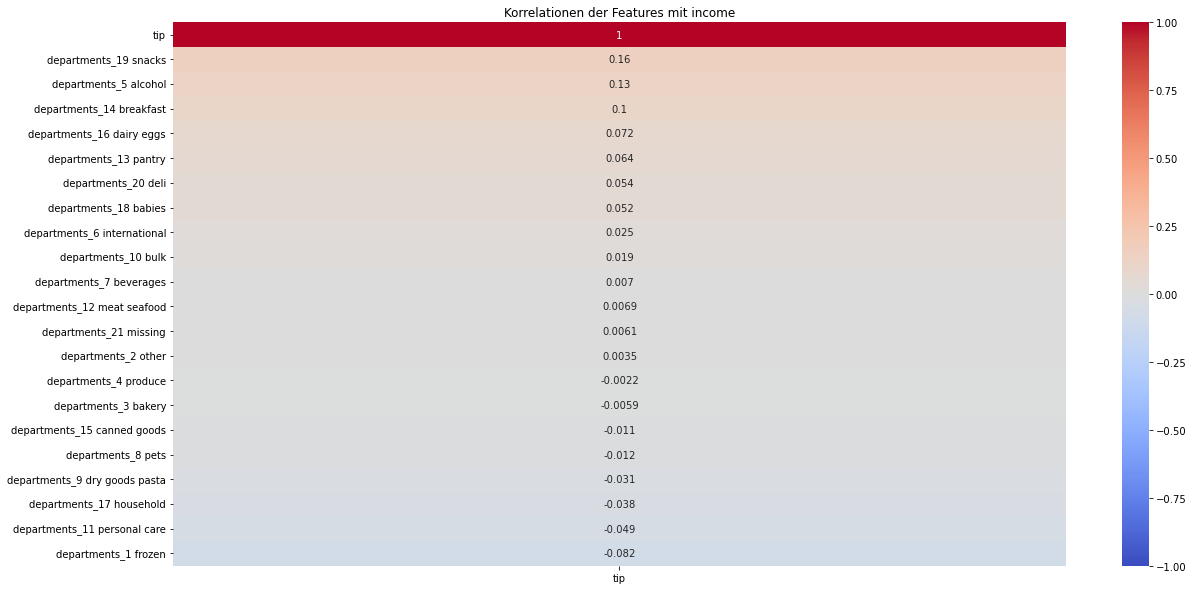

In [147]:
plt.figure(figsize=(20, 10))
corr_with_income = instacart_train_departements.corr()[['tip']].sort_values(by='tip', ascending=False)
heatmap = sns.heatmap(corr_with_income, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Korrelationen der Features mit income')
plt.show()

## Datenqualität analysieren

### Outliers
In den Datensatz konnten keine Outlier identifiziert werden.

### Missing Values
Missing Values werden entfernt. Bei den entfernten Werten handelt es sich jeweils um die erste Bestellung der Nutzer. Erste Bestellungen kommen in dem Test-Datensatz nicht vor. Daher können diese entfernt werden.

In [148]:
instacart_train = instacart_train.dropna()

In [149]:
instacart_train.isna().sum()

order_id                              0
tip                                   0
user_id                               0
eval_set                              0
order_number                          0
                                     ..
mean_days_since_prior_oder_by_user    0
weeks_since_prior_order               0
amount_ordered_products               0
amount_reordered_products             0
factor_reordered_products             0
Length: 171, dtype: int64

# Data Preparation

## Feature Engineering

### Discretization

In [150]:
dow_day_dict = {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

instacart_train['order_dow_discretized'] = instacart_train['order_dow'].map(dow_day_dict, na_action='ignore')
instacart_train = instacart_train.drop(columns=['order_dow'])
instacart_prod['order_dow_discretized'] = instacart_prod['order_dow'].map(dow_day_dict, na_action='ignore')
instacart_prod = instacart_prod.drop(columns=['order_dow'])


In [151]:
dow_hod_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}

instacart_train['order_hod_discretized'] = instacart_train['order_hour_of_day'].map(dow_hod_dict, na_action='ignore')
instacart_train = instacart_train.drop(columns=['order_hour_of_day'])
instacart_prod['order_hod_discretized'] = instacart_prod['order_hour_of_day'].map(dow_hod_dict, na_action='ignore')
instacart_prod = instacart_prod.drop(columns=['order_hour_of_day'])

In [152]:
instacart_train.head()

,order_id,tip,user_id,eval_set,order_number,days_since_prior_order,aisles_1 prepared soups salads,aisles_2 specialty cheeses,aisles_3 energy granola bars,aisles_4 instant foods,...,mean_tip_user,previous_order_tip,3_previous_tip_user,mean_days_since_prior_oder_by_user,weeks_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products,order_dow_discretized,order_hod_discretized
1,2398795,1,1,prior,2,15.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.333333,20.0,2.0,6,3,0.5,0,1
2,473747,1,1,prior,3,21.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.666667,20.0,3.0,5,3,0.6,0,1
3,2254736,1,1,prior,4,29.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.000000,20.0,4.0,5,5,1.0,0,1
4,431534,1,1,prior,5,28.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.000000,20.0,4.0,8,5,0.6,0,1
5,3367565,1,1,prior,6,19.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.000000,20.0,2.0,4,4,1.0,0,1


## Feature Selection
- Delete eval_set, da es keinen logischen Zusammenhang gibt.
- Delete order_id, da es eine unique ID ist (führt zu Overfitting)
- Delete user_id, da es eine unique ID ist (führt zu Overfitting)

In [154]:
instacart_train_order_id = instacart_train['order_id']
instacart_train = instacart_train.drop(columns=['eval_set', 'order_id', 'user_id'])
instacart_prod_order_id = instacart_prod['order_id']
instacart_prod = instacart_prod.drop(columns=['eval_set', 'order_id', 'user_id'])

In [155]:
instacart_train_reduced = instacart_train.sample(500000)

X = instacart_train_reduced.drop(columns=['tip'])
y = instacart_train_reduced['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [156]:
clf = RandomForestClassifier(n_estimators=5)
sel = SelectFromModel(clf, threshold=0.002).fit(X_train, y_train)

mask = sel.get_support()
chi2_feature = X.loc[:,mask].columns.tolist()

X_train = X_train.loc[:,mask]
X_test = X_test.loc[:,mask]
len(chi2_feature)

91

## Scaling
Um die unabhängigen Features in den Daten zu standardisieren wird eine MinMax-Skalierung angewendet. Welche die beobachteten zwischen 0 und 1 abhängig der vorherigen Verteilung reskaliert.

In [157]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

## Train Test Split

Anwendung eines 80/20 Train Test Splits. 20% des Datensatzes werden somit für die Evaluation der Modelle zurückgehalten. Auf den verbleibenden 80% der Daten werden Cross-Fold-Validation-Methoden genutzt, um den Erkenntnissgewinn zu maximieren. 

In [158]:
clf = DummyClassifier(strategy="most_frequent")
dummy_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(dummy_base_scores)
print("%0.3f accuracy with a standard deviation of %0.2f" % (dummy_base_scores.mean(), dummy_base_scores.std()))

[0.574125  0.574125  0.5741125 0.5741125 0.5741125]
0.574 accuracy with a standard deviation of 0.00


In [159]:
clf = KNeighborsClassifier()
knn_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(knn_base_scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (knn_base_scores.mean(), knn_base_scores.std()))

[0.7019125 0.70185   0.7036625 0.7013    0.7016375]
0.702 accuracy with a standard deviation of 0.001


In [160]:
clf = DecisionTreeClassifier()
dt_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(dt_base_scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (dt_base_scores.mean(), dt_base_scores.std()))

[0.7089   0.7088   0.709975 0.709325 0.70935 ]
0.709 accuracy with a standard deviation of 0.000


In [161]:
clf = RandomForestClassifier(n_estimators=5) #n_estimators=5
rf_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(rf_base_scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (rf_base_scores.mean(), rf_base_scores.std()))

[0.7495875 0.7444    0.7475    0.746     0.7448125]
0.746 accuracy with a standard deviation of 0.002


In [162]:
clf = xgb.XGBClassifier()
xgb_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(xgb_base_scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (xgb_base_scores.mean(), xgb_base_scores.std()))

[0.788025  0.7882875 0.79065   0.7904125 0.7874625]
0.789 accuracy with a standard deviation of 0.001


In [163]:
clf = Perceptron()
perceptron_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(perceptron_base_scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (perceptron_base_scores.mean(), perceptron_base_scores.std()))

[0.7384875 0.7525625 0.7305125 0.6993125 0.74995  ]
0.734 accuracy with a standard deviation of 0.019


In [164]:
clf = MLPClassifier(random_state=1, max_iter=30)
mlp_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(mlp_base_scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (mlp_base_scores.mean(), mlp_base_scores.std()))

c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.7846125 0.7851875 0.785325  0.7863    0.784225 ]
0.785 accuracy with a standard deviation of 0.001


c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


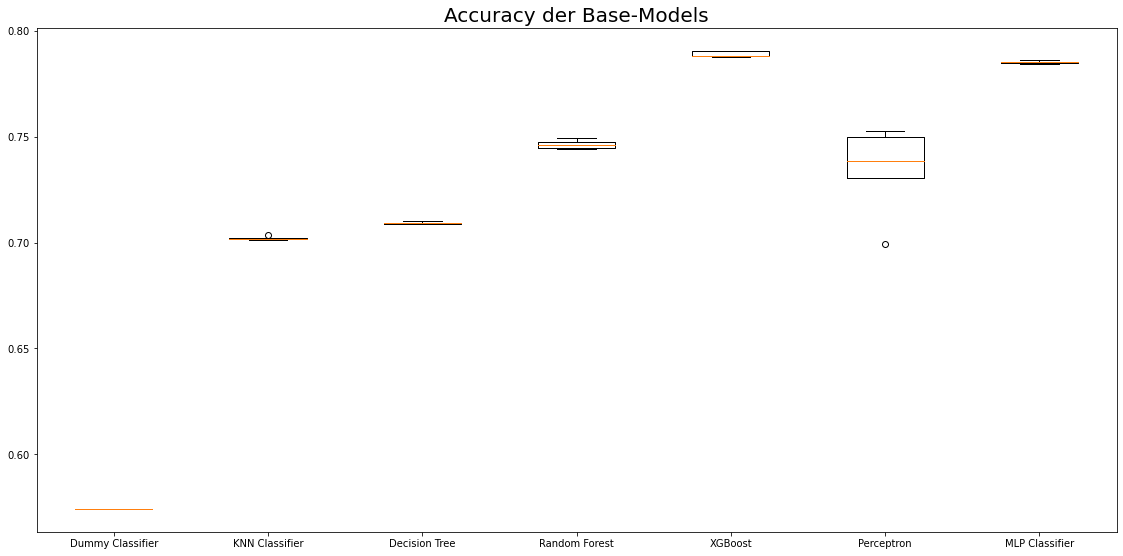

In [165]:
baseline_model = [dummy_base_scores, knn_base_scores, dt_base_scores, rf_base_scores, xgb_base_scores, perceptron_base_scores, mlp_base_scores]

fig = plt.figure(figsize =(15, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title(label = 'Accuracy der Base-Models', fontsize = 20)
 
# Creating plot
bp = ax.boxplot(baseline_model)

# rename ticks 
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Dummy Classifier', 'KNN Classifier', 'Decision Tree', 'Random Forest', 'XGBoost', 'Perceptron', 'MLP Classifier'])
# show plot
plt.show()

# Hyperparameter Optimierung

Hyperparameter Tuning Gradient Boosting Classifier mit diversen n_estimators, max_depths und learning_rates

In [166]:
from sklearn.model_selection import RandomizedSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

random_search = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic'), param_distributions=params, n_iter=15, scoring='roc_auc', n_jobs=4, cv=5, verbose=10, random_state=0)

random_search.fit(X_train, y_train)

print(f'Die besten Parameter für den Gradient Boosting Classifier: {random_search.best_params_} \n')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Die besten Parameter für den Gradient Boosting Classifier: {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 0.8} 



# Evaluation

## Final model
Basierend auf der Hyperparamter Optimierung wurde das folgende Modell trainiert. 

In [188]:
X = instacart_train.drop(columns=['tip'])
y = instacart_train['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

clf = RandomForestClassifier(n_estimators=5)
sel = SelectFromModel(clf, threshold=0.002).fit(X_train, y_train)

mask = sel.get_support()
chi2_feature = X.loc[:,mask].columns.tolist()

X_train = X_train.loc[:,mask]
X_test = X_test.loc[:,mask]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [189]:
clf = xgb.XGBClassifier(objective='binary:logistic', subsample=0.8, min_child_weight=1, max_depth=5, gamma=1, colsample_bytree=0.8).fit(X_train, y_train)
y_rf_pred_training = clf.predict(X_train)
y_rf_pred = clf.predict(X_test)

## Confusion Matrix
Die Confusion Matrix zeigt die Performance des Modells basierend auf Actual Values vs. Predicted Values.

<Figure size 1800x1440 with 0 Axes>

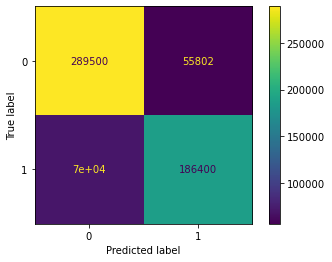

In [190]:
plt.figure(figsize=(25, 20))
ConfusionMatrixDisplay.from_predictions(y_test, y_rf_pred)
plt.show()

## Kennzahlen
Um die Güte des Machine Learning-Modells zu klassifizieren werden die Metriken Accuracy, Precision, Recall und F1-Score verwendet.

### Accuracy on Test and Training Data
Die Accuracy beschreibt die Anzahl der korrekten Vorhersagen im Verhältnis zu der Gesamtzahl der Predictions.

In [192]:
accuracy_rf_clf_on_training_data = accuracy_score(y_train, y_rf_pred_training)
print(f'XGBoost accuracy on training data:  {accuracy_rf_clf_on_training_data}')
accuracy_rf_clf = accuracy_score(y_test, y_rf_pred)
print(f'XGBoost accuracy on test data:  {accuracy_rf_clf}')

XGBoost accuracy on training data:  0.7915204916466273
XGBoost accuracy on test data:  0.7908823348561571


### Precision on Test and Training Data
Die Precision beschreibt bei vielen der Bestellungen, bei denen ein tip prognostiziert wurde, auch tatsächlich ein tip gegeben wurde. 

In [193]:
precision_rf_clf_on_training_data = precision_score(y_train, y_rf_pred_training)
print(f'XGBoost precision on training data:  {precision_rf_clf_on_training_data}')
precision_rf_clf = precision_score(y_test, y_rf_pred)
print(f'XGBoost precision on test data:  {precision_rf_clf}')

XGBoost precision on training data:  0.771079784284754
XGBoost precision on test data:  0.7696055358750135


### Recall on Test and Training Data
Der Recall beschreibt bei wie vielen der Bestellungen, bei denen ein Tip vergeben wurde, dieser auch durch das Modell korrekt prognostiziert wurden.

In [194]:
recall_rf_clf_on_training_data = recall_score(y_train, y_rf_pred_training)
print(f'XGBoost recall on training data:  {recall_rf_clf_on_training_data}')
recall_rf_clf = recall_score(y_test, y_rf_pred)
print(f'XGBoost Forest recall on test data:  {recall_rf_clf}')

XGBoost recall on training data:  0.7272438665974601
XGBoost Forest recall on test data:  0.7269011936934302


### F1-Score on Test and Training Data 
Der F1-Score ist das harmonische Mittel aus Precision und Recall.

In [195]:
f1_score_rf_clf_on_training_data = f1_score(y_train, y_rf_pred_training)
print(f'XGBoost f1_score on training data:  {f1_score_rf_clf_on_training_data}')
f1_score_rf_clf = f1_score(y_test, y_rf_pred)
print(f'XGBoost f1_score on test data:  {f1_score_rf_clf}')

XGBoost f1_score on training data:  0.748520579579989
XGBoost f1_score on test data:  0.7476440588569149


## Feature Importance

### Feature importance based on Mean Decrease in Impurity

Impurits Decrease importances sind bekannt dafür, dass Sie Features mit hoher Kardinalität bevorzugen. Daher wird neber dem Mean Decrease auch die Permutation Importance betrachtet.

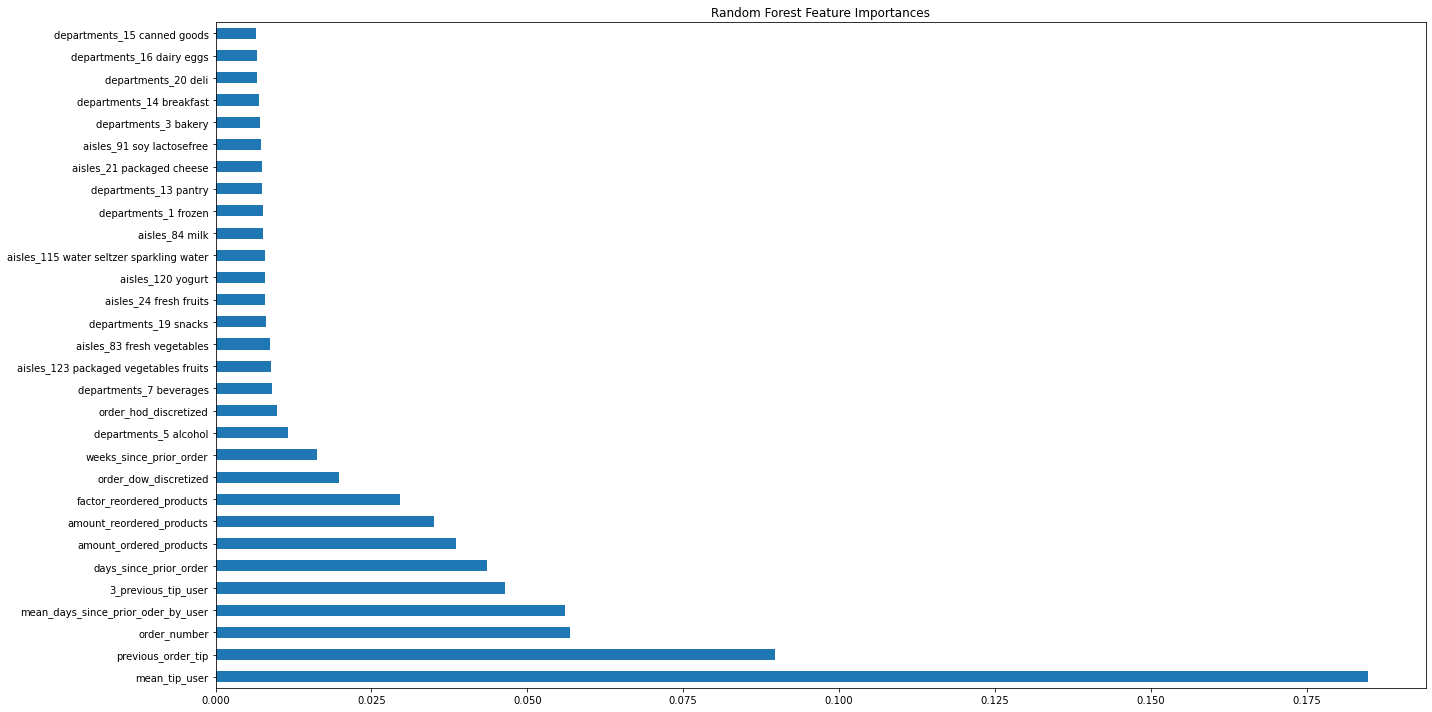

In [174]:
rf_clf = RandomForestClassifier(n_estimators=5)
rf_clf.fit(X_train, y_train)

X_selected_columns = X.loc[:,mask]
X_selected_columns

mdi_importances = pd.Series(
    rf_clf[-1].feature_importances_, index=X_selected_columns.columns
).sort_values(ascending=False).head(30)

ax = mdi_importances.plot.barh(figsize=(20,10))
ax.set_title("Random Forest Feature Importances")
ax.figure.tight_layout()

### Feature importance based on Permutation importance

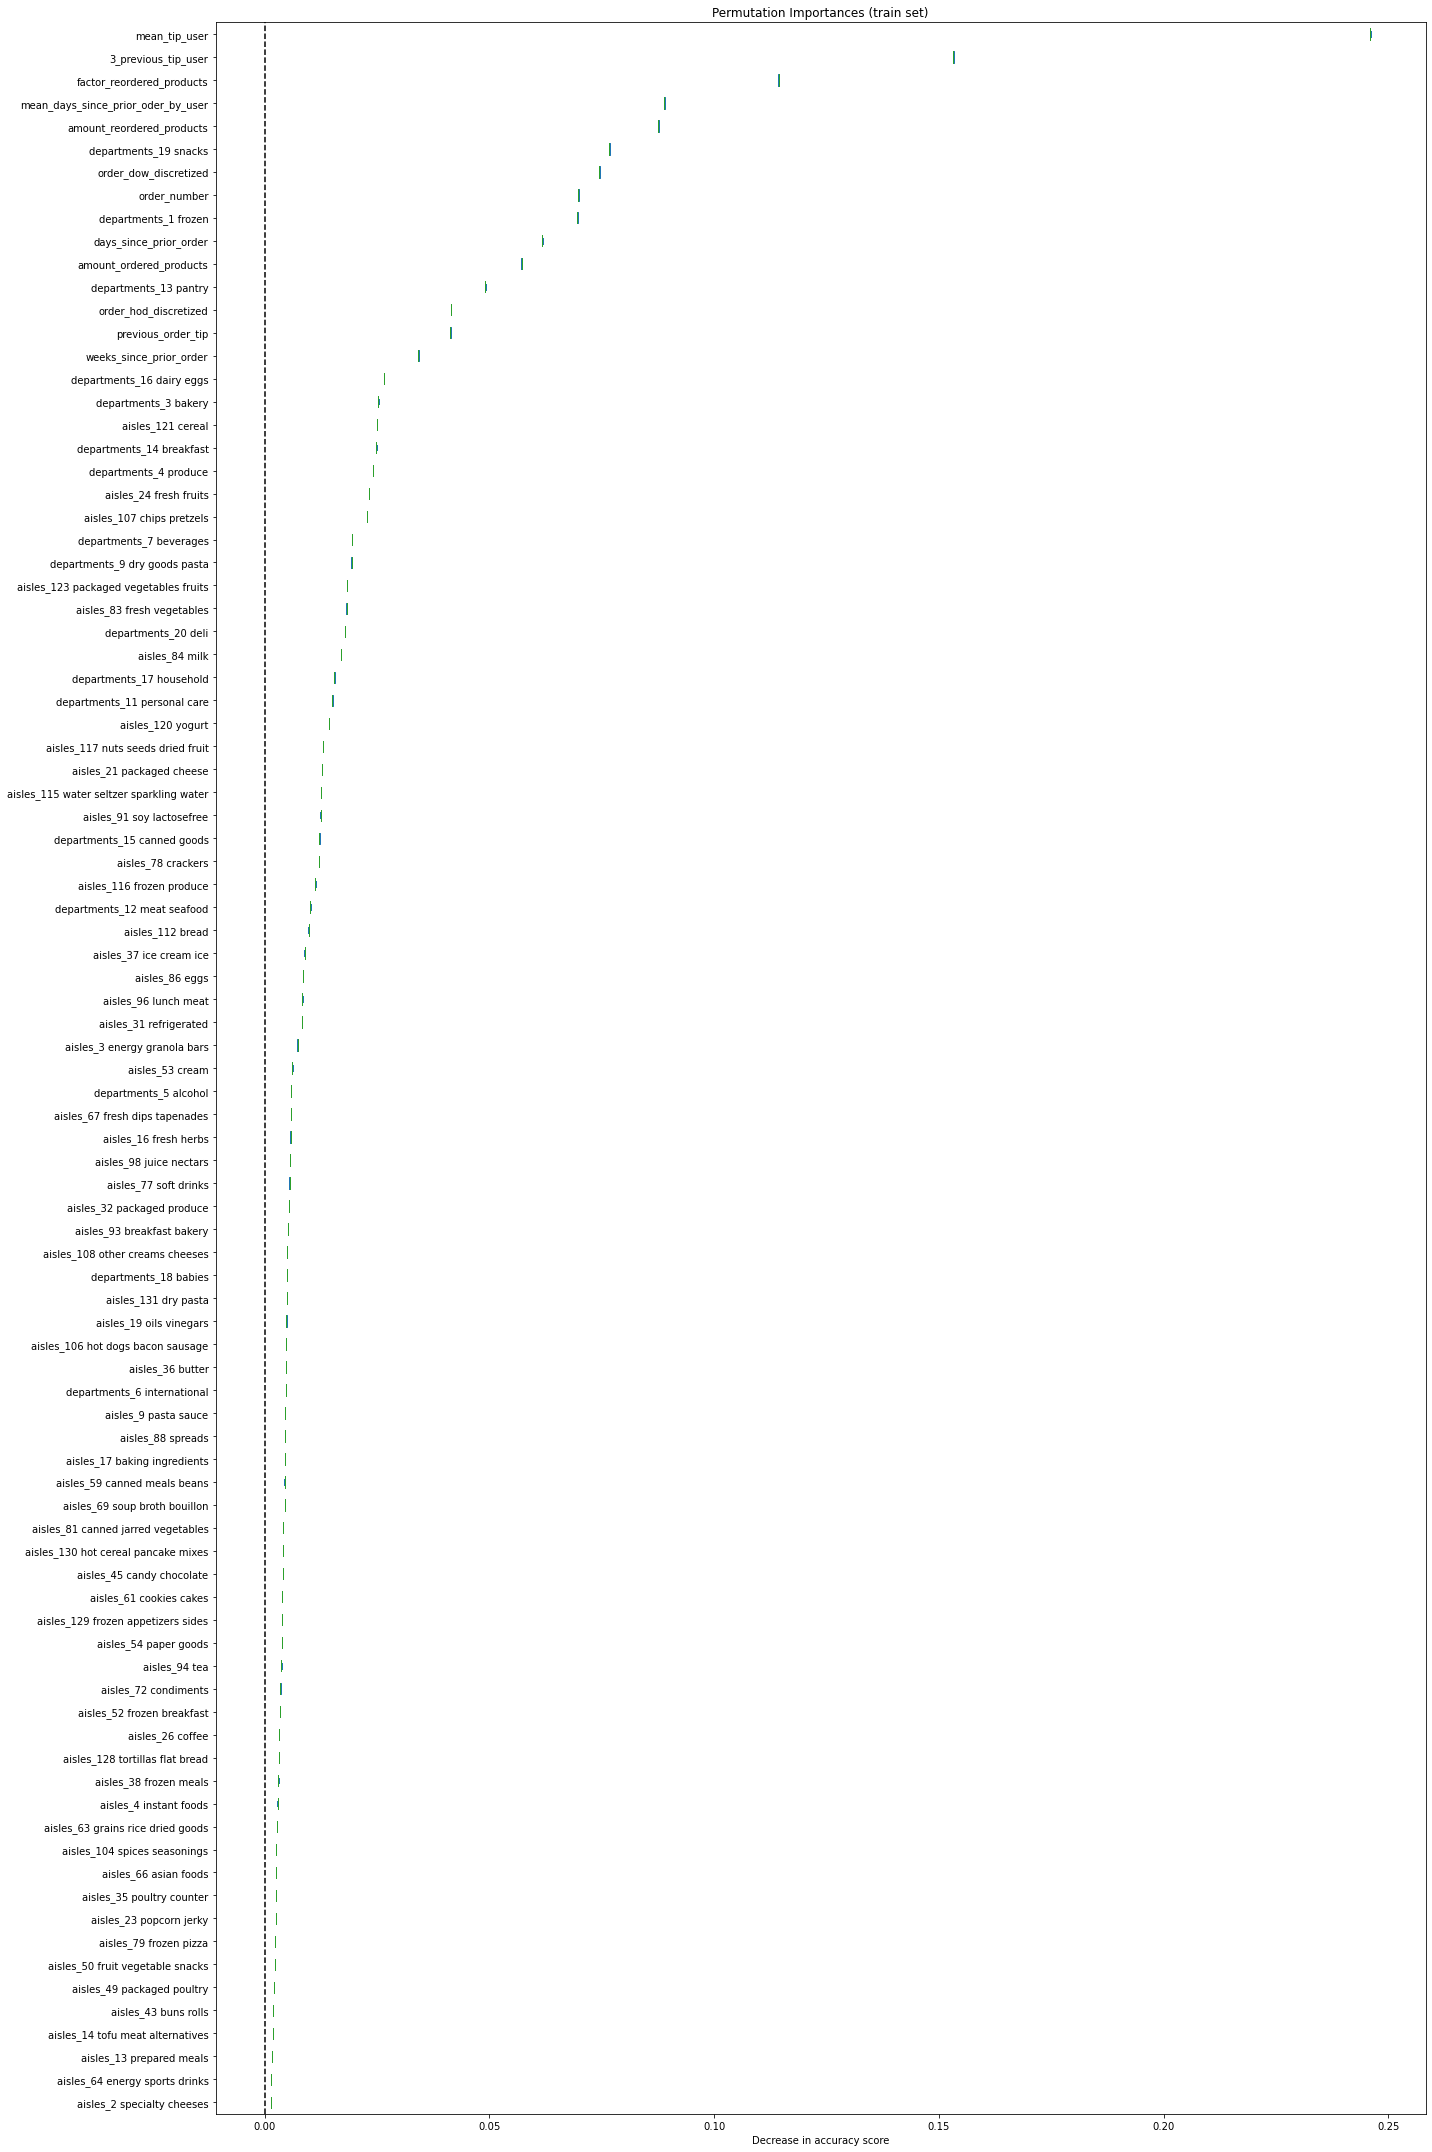

In [175]:
from sklearn.inspection import permutation_importance

rf_clf = RandomForestClassifier(n_estimators=1)
rf_clf.fit(X_train, y_train)

X_selected_columns = X.loc[:,mask]
X_selected_columns

permutation_importances = permutation_importance(rf_clf, X_train, y_train, n_repeats=3, random_state=0)

sorted_importances_idx = permutation_importances.importances_mean.argsort()
importances = pd.DataFrame(
    permutation_importances.importances[sorted_importances_idx].T,
    columns=X_selected_columns.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10, figsize=(20,30))
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Production
Apply the trained model to the production set.

In [176]:
X_prod = instacart_prod.drop(columns=['tip'])
y_prod = instacart_prod['tip']

X_prod = X_prod.loc[:,mask]
X_prod = scaler.transform(X_prod)

y_pred_prod = clf.predict(X_prod)

In [185]:
y_pred_prod_df = pd.DataFrame(y_pred_prod, columns=['Tip'])

tip_dict = {0: 'F', 1: 'T'}
y_pred_prod_df['Tip'] = y_pred_prod_df['Tip'].map(tip_dict, na_action='ignore')

result = pd.concat([instacart_prod_order_id, y_pred_prod_df['Tip']], axis=1)
result.to_csv('tip_testdaten.csv')

In [187]:
y_pred_prod_df.value_counts()

Tip
F      91857
T      39352
dtype: int64